# Transition State Search (NEBs)

FAIR chemistry models can be used to enumerate and study reaction pathways via transition state search tools built into ASE or in packages like Sella via the ASE interface.

The first section of this tutorial walks through how to use the CatTsunami tools to automatically enumerate a number of hypothetical initial/final configurations for various types of reactions on a heterogeneous catalyst surface. If you already have a NEB you're looking to optimize, you can jump straight to the last section (Run NEBs)!

Since the NEB calculations here can be a bit time consuming, we'll use a small number of steps during the documentation testing, and otherwise use a reasonable guess.

In [1]:
import os

# Use a small number of steps here to keep the docs fast during CI, but otherwise do quite reasonable settings.
fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    optimization_steps = 20
else:
    optimization_steps = 300

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

## Do enumerations in an AdsorbML style

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
from ase.io import read
from ase.mep import DyNEB
from ase.optimize import BFGS
from fairchem.applications.cattsunami.core import Reaction
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from x3dase.x3d import X3D

# Instantiate the reaction class for the reaction of interest
reaction = Reaction(
    reaction_str_from_db="*CH -> *C + *H",
    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
    adsorbate_db_path=ADSORBATE_PKL_PATH,
)

In [3]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(
    adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product1 = Adsorbate(
    adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product2 = Adsorbate(
    adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)

In [4]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-33", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(0, 0, 1))

In [5]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 5 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=reactant,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product1_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product1,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product2_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product2,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list

In [6]:
# Instantiate the calculator
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [7]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:21:26     -301.559904        4.135691
BFGS:    1 21:21:26     -301.933976        3.385659
BFGS:    2 21:21:26     -302.881417        3.209412


BFGS:    3 21:21:26     -303.005156        3.163942
BFGS:    4 21:21:26     -303.245962        2.316478
BFGS:    5 21:21:26     -303.455943        3.825987


BFGS:    6 21:21:26     -303.580894        2.153085
BFGS:    7 21:21:26     -303.903721        1.280130
BFGS:    8 21:21:26     -304.125447        2.062244


BFGS:    9 21:21:26     -304.208176        1.729804
BFGS:   10 21:21:26     -304.493724        1.191859
BFGS:   11 21:21:26     -304.540847        1.295915


BFGS:   12 21:21:27     -304.588931        0.652929
BFGS:   13 21:21:27     -304.600759        0.379222
BFGS:   14 21:21:27     -304.613630        0.351042


BFGS:   15 21:21:27     -304.643511        0.277552
BFGS:   16 21:21:27     -304.648665        0.232640
BFGS:   17 21:21:27     -304.653575        0.228980


BFGS:   18 21:21:27     -304.659393        0.245395
BFGS:   19 21:21:27     -304.668503        0.302512
BFGS:   20 21:21:27     -304.676201        0.221255


BFGS:   21 21:21:27     -304.680271        0.149514
BFGS:   22 21:21:27     -304.682727        0.135623
BFGS:   23 21:21:28     -304.684974        0.137810


BFGS:   24 21:21:28     -304.687160        0.137113
BFGS:   25 21:21:28     -304.689043        0.107181
BFGS:   26 21:21:28     -304.690029        0.071395


BFGS:   27 21:21:28     -304.690477        0.073516
BFGS:   28 21:21:28     -304.690871        0.078368
BFGS:   29 21:21:28     -304.691328        0.077547


BFGS:   30 21:21:28     -304.691798        0.060814
BFGS:   31 21:21:28     -304.692140        0.035223
      Step     Time          Energy          fmax
BFGS:    0 21:21:28     -300.908528        4.035530


BFGS:    1 21:21:28     -301.316240        3.256709
BFGS:    2 21:21:28     -302.504168        3.643420
BFGS:    3 21:21:29     -302.490270        6.612797


BFGS:    4 21:21:29     -302.870095        2.749739
BFGS:    5 21:21:29     -303.051438        1.160766
BFGS:    6 21:21:29     -303.087604        1.199993


BFGS:    7 21:21:29     -303.117964        0.791196
BFGS:    8 21:21:29     -303.140897        0.954710
BFGS:    9 21:21:29     -303.182801        0.584174


BFGS:   10 21:21:29     -303.187724        0.218188
BFGS:   11 21:21:29     -303.189469        0.168709
BFGS:   12 21:21:29     -303.191709        0.317367


BFGS:   13 21:21:29     -303.195332        0.410030
BFGS:   14 21:21:29     -303.199034        0.355856
BFGS:   15 21:21:30     -303.201253        0.206524


BFGS:   16 21:21:30     -303.202630        0.135159
BFGS:   17 21:21:30     -303.204428        0.254485
BFGS:   18 21:21:30     -303.207141        0.334876


BFGS:   19 21:21:30     -303.210938        0.298413
BFGS:   20 21:21:30     -303.213433        0.179335
BFGS:   21 21:21:30     -303.215409        0.162885


BFGS:   22 21:21:30     -303.219890        0.354967
BFGS:   23 21:21:30     -303.264260        1.180185
BFGS:   24 21:21:30     -303.413603        1.345195


BFGS:   25 21:21:30     -303.477186        2.753227
BFGS:   26 21:21:30     -303.601005        1.894634
BFGS:   27 21:21:31     -303.822051        1.985561


BFGS:   28 21:21:31     -303.945388        3.247328
BFGS:   29 21:21:31     -304.072314        2.458534
BFGS:   30 21:21:31     -304.157518        2.167520


BFGS:   31 21:21:31     -304.382388        1.308155
BFGS:   32 21:21:31     -304.427669        1.611916
BFGS:   33 21:21:31     -304.471749        1.019780


BFGS:   34 21:21:31     -304.514530        0.525254
BFGS:   35 21:21:31     -304.539387        0.526387
BFGS:   36 21:21:31     -304.593842        0.439381


BFGS:   37 21:21:31     -304.612786        0.370549
BFGS:   38 21:21:31     -304.624491        0.365034
BFGS:   39 21:21:32     -304.635812        0.360289


BFGS:   40 21:21:32     -304.650688        0.311705
BFGS:   41 21:21:32     -304.664475        0.297381
BFGS:   42 21:21:32     -304.673950        0.236470


BFGS:   43 21:21:32     -304.681179        0.150191
BFGS:   44 21:21:32     -304.684136        0.140648
BFGS:   45 21:21:32     -304.686332        0.123198


BFGS:   46 21:21:32     -304.688079        0.104013
BFGS:   47 21:21:32     -304.689672        0.060954
BFGS:   48 21:21:32     -304.690783        0.068064


BFGS:   49 21:21:32     -304.691400        0.056187
BFGS:   50 21:21:32     -304.691672        0.034738
      Step     Time          Energy          fmax
BFGS:    0 21:21:33     -301.158751        4.084730


BFGS:    1 21:21:33     -301.534147        3.383734
BFGS:    2 21:21:33     -302.535016        3.313709
BFGS:    3 21:21:33     -302.595553        4.500926


BFGS:    4 21:21:33     -302.862223        2.441974
BFGS:    5 21:21:33     -303.017565        1.667021
BFGS:    6 21:21:33     -303.058770        1.172722


BFGS:    7 21:21:33     -303.168073        1.698970
BFGS:    8 21:21:33     -303.224875        1.412170
BFGS:    9 21:21:33     -303.297109        0.650671


BFGS:   10 21:21:33     -303.323912        0.691955
BFGS:   11 21:21:33     -303.475291        1.839907
BFGS:   12 21:21:34     -303.595099        2.288488


BFGS:   13 21:21:34     -303.690005        2.428493
BFGS:   14 21:21:34     -303.869534        1.263397
BFGS:   15 21:21:34     -303.999053        1.802495


BFGS:   16 21:21:34     -304.000353        2.645626
BFGS:   17 21:21:34     -304.118169        0.825419
BFGS:   18 21:21:34     -304.153311        0.594334


BFGS:   19 21:21:34     -304.213298        0.763528
BFGS:   20 21:21:34     -304.240677        0.982603
BFGS:   21 21:21:35     -304.302800        1.301671


BFGS:   22 21:21:35     -304.378218        1.301300
BFGS:   23 21:21:35     -304.446937        1.197630
BFGS:   24 21:21:35     -304.538828        1.014373


BFGS:   25 21:21:35     -304.564009        0.558454
BFGS:   26 21:21:35     -304.591507        0.444433
BFGS:   27 21:21:35     -304.591179        0.569601


BFGS:   28 21:21:35     -304.614446        0.334817
BFGS:   29 21:21:35     -304.625359        0.310577
BFGS:   30 21:21:35     -304.635686        0.279366


BFGS:   31 21:21:35     -304.643219        0.295205
BFGS:   32 21:21:35     -304.649397        0.334714
BFGS:   33 21:21:36     -304.660003        0.359403


BFGS:   34 21:21:36     -304.671232        0.280519
BFGS:   35 21:21:36     -304.677895        0.228776
BFGS:   36 21:21:36     -304.680824        0.170365


BFGS:   37 21:21:36     -304.682908        0.138678
BFGS:   38 21:21:36     -304.685336        0.172475
BFGS:   39 21:21:36     -304.687948        0.162861


BFGS:   40 21:21:36     -304.689890        0.095646
BFGS:   41 21:21:36     -304.690769        0.062064
BFGS:   42 21:21:36     -304.691071        0.044797


      Step     Time          Energy          fmax
BFGS:    0 21:21:36     -301.030054        4.103750
BFGS:    1 21:21:36     -301.413382        3.442569
BFGS:    2 21:21:37     -302.465662        3.354088


BFGS:    3 21:21:37     -302.442906        5.871673
BFGS:    4 21:21:37     -302.776216        2.670671
BFGS:    5 21:21:37     -302.930860        1.309724


BFGS:    6 21:21:37     -303.003370        1.642763
BFGS:    7 21:21:37     -303.042479        0.878758
BFGS:    8 21:21:37     -303.117341        1.564995


BFGS:    9 21:21:37     -303.162261        1.288289
BFGS:   10 21:21:37     -303.202652        0.495918
BFGS:   11 21:21:37     -303.210326        0.320774


BFGS:   12 21:21:37     -303.219823        0.393685
BFGS:   13 21:21:37     -303.227163        0.404738
BFGS:   14 21:21:38     -303.232022        0.307453


BFGS:   15 21:21:38     -303.235266        0.297132
BFGS:   16 21:21:38     -303.239960        0.395559
BFGS:   17 21:21:38     -303.252264        0.681297


BFGS:   18 21:21:38     -303.324811        1.484139
BFGS:   19 21:21:38     -303.533429        1.713585
BFGS:   20 21:21:38     -303.784936        1.875986


BFGS:   21 21:21:38     -303.850036        2.016882
BFGS:   22 21:21:38     -303.944447        1.264075
BFGS:   23 21:21:38     -304.029258        0.731118


BFGS:   24 21:21:38     -304.112561        0.780137
BFGS:   25 21:21:38     -304.128036        0.643778
BFGS:   26 21:21:39     -304.156817        0.411825


BFGS:   27 21:21:39     -304.170256        0.270722
BFGS:   28 21:21:39     -304.176979        0.187076
BFGS:   29 21:21:39     -304.180614        0.168000


BFGS:   30 21:21:39     -304.186058        0.251111
BFGS:   31 21:21:39     -304.191015        0.270669
BFGS:   32 21:21:39     -304.194420        0.201020


BFGS:   33 21:21:39     -304.196669        0.157859
BFGS:   34 21:21:39     -304.199937        0.227431
BFGS:   35 21:21:39     -304.204740        0.373666


BFGS:   36 21:21:39     -304.212047        0.525567
BFGS:   37 21:21:40     -304.220790        0.547595
BFGS:   38 21:21:40     -304.231696        0.432716


BFGS:   39 21:21:40     -304.255489        0.367592
BFGS:   40 21:21:40     -304.269223        0.431544
BFGS:   41 21:21:40     -304.286381        0.627448


BFGS:   42 21:21:40     -304.298550        0.719235
BFGS:   43 21:21:40     -304.311160        0.310467
BFGS:   44 21:21:40     -304.322237        0.251208


BFGS:   45 21:21:40     -304.329471        0.240775
BFGS:   46 21:21:40     -304.334492        0.223850
BFGS:   47 21:21:40     -304.339292        0.174173


BFGS:   48 21:21:40     -304.344077        0.173808
BFGS:   49 21:21:41     -304.348751        0.165504
BFGS:   50 21:21:41     -304.351840        0.104367


BFGS:   51 21:21:41     -304.353092        0.107473
BFGS:   52 21:21:41     -304.354325        0.101848
BFGS:   53 21:21:41     -304.355196        0.082066


BFGS:   54 21:21:41     -304.356041        0.066610
BFGS:   55 21:21:41     -304.356662        0.052008
BFGS:   56 21:21:41     -304.356968        0.028533


      Step     Time          Energy          fmax
BFGS:    0 21:21:41     -301.072089        4.059658
BFGS:    1 21:21:41     -301.466616        3.049848
BFGS:    2 21:21:41     -302.570351        3.653797


BFGS:    3 21:21:41     -302.650663        4.920840
BFGS:    4 21:21:42     -302.965099        2.456672
BFGS:    5 21:21:42     -303.065841        2.648247


BFGS:    6 21:21:42     -303.115338        0.576087
BFGS:    7 21:21:42     -303.132038        0.490482
BFGS:    8 21:21:42     -303.221202        0.715285


BFGS:    9 21:21:42     -303.234074        0.440692
BFGS:   10 21:21:42     -303.243181        0.307658
BFGS:   11 21:21:42     -303.259068        0.497338


BFGS:   12 21:21:42     -303.274175        0.630776
BFGS:   13 21:21:42     -303.290843        0.708316
BFGS:   14 21:21:42     -303.308347        0.812313


BFGS:   15 21:21:42     -303.352936        1.258093
BFGS:   16 21:21:43     -303.417337        2.833778
BFGS:   17 21:21:43     -303.632049        1.464014


BFGS:   18 21:21:43     -303.823583        1.760925
BFGS:   19 21:21:43     -303.881903        1.736192
BFGS:   20 21:21:43     -304.023625        1.208496


BFGS:   21 21:21:43     -304.089765        1.198233
BFGS:   22 21:21:43     -304.160937        0.811168
BFGS:   23 21:21:43     -304.184947        0.643935


BFGS:   24 21:21:43     -304.227324        0.518364
BFGS:   25 21:21:43     -304.243638        0.449169
BFGS:   26 21:21:43     -304.259099        0.394393


BFGS:   27 21:21:43     -304.276134        0.348052
BFGS:   28 21:21:44     -304.290189        0.367742
BFGS:   29 21:21:44     -304.301446        0.468103


BFGS:   30 21:21:44     -304.313170        0.459952
BFGS:   31 21:21:44     -304.323018        0.367782
BFGS:   32 21:21:44     -304.331951        0.212329


BFGS:   33 21:21:44     -304.342355        0.262987
BFGS:   34 21:21:44     -304.346003        0.220290
BFGS:   35 21:21:44     -304.349506        0.185009


BFGS:   36 21:21:44     -304.353231        0.130338
BFGS:   37 21:21:44     -304.354700        0.067786
BFGS:   38 21:21:44     -304.355394        0.069365


BFGS:   39 21:21:44     -304.355861        0.051385
BFGS:   40 21:21:45     -304.356278        0.044565
      Step     Time          Energy          fmax
BFGS:    0 21:21:45     -301.268603        4.157227


BFGS:    1 21:21:45     -301.648701        3.616933
BFGS:    2 21:21:45     -302.668828        3.146492
BFGS:    3 21:21:45     -302.640344        6.068588


BFGS:    4 21:21:45     -303.011285        2.563778
BFGS:    5 21:21:45     -303.175437        1.521618
BFGS:    6 21:21:45     -303.359544        2.826492


BFGS:    7 21:21:45     -303.488339        2.359145
BFGS:    8 21:21:45     -303.767254        1.347729
BFGS:    9 21:21:45     -303.781262        1.944742


BFGS:   10 21:21:45     -303.916013        0.862541
BFGS:   11 21:21:46     -303.982942        0.771168
BFGS:   12 21:21:46     -304.086177        0.515263


BFGS:   13 21:21:46     -304.107522        0.552642
BFGS:   14 21:21:46     -304.138116        0.762027
BFGS:   15 21:21:46     -304.177619        0.793836


BFGS:   16 21:21:46     -304.221879        0.664587
BFGS:   17 21:21:46     -304.263776        0.876856
BFGS:   18 21:21:46     -304.304467        1.015517


BFGS:   19 21:21:46     -304.350914        0.850522
BFGS:   20 21:21:46     -304.432397        0.746578
BFGS:   21 21:21:46     -304.470202        0.838785


BFGS:   22 21:21:46     -304.495915        1.049707
BFGS:   23 21:21:47     -304.527452        0.679569
BFGS:   24 21:21:47     -304.547009        0.557519


BFGS:   25 21:21:47     -304.570747        0.445707
BFGS:   26 21:21:47     -304.596468        0.598845
BFGS:   27 21:21:47     -304.623415        0.614700


BFGS:   28 21:21:47     -304.643415        0.496468
BFGS:   29 21:21:47     -304.659724        0.382007
BFGS:   30 21:21:47     -304.670166        0.347993


BFGS:   31 21:21:47     -304.678882        0.262668
BFGS:   32 21:21:47     -304.684685        0.149354
BFGS:   33 21:21:47     -304.687423        0.080496


BFGS:   34 21:21:47     -304.688462        0.072829
BFGS:   35 21:21:48     -304.689020        0.091680
BFGS:   36 21:21:48     -304.689624        0.099491


BFGS:   37 21:21:48     -304.690380        0.088799
BFGS:   38 21:21:48     -304.691171        0.056799
BFGS:   39 21:21:48     -304.691669        0.030173


      Step     Time          Energy          fmax
BFGS:    0 21:21:48     -300.754673        4.032273
BFGS:    1 21:21:48     -301.159535        3.511008
BFGS:    2 21:21:48     -302.368430        3.463815


BFGS:    3 21:21:48     -301.881196       11.340914
BFGS:    4 21:21:48     -302.656205        3.024625
BFGS:    5 21:21:48     -302.808860        2.406164


BFGS:    6 21:21:48     -302.995842        2.284701
BFGS:    7 21:21:49     -303.063845        0.848616
BFGS:    8 21:21:49     -303.091356        0.769267


BFGS:    9 21:21:49     -303.169163        0.973792
BFGS:   10 21:21:49     -303.180680        0.278799
BFGS:   11 21:21:49     -303.183430        0.114438


BFGS:   12 21:21:49     -303.185451        0.118575
BFGS:   13 21:21:49     -303.186725        0.123022
BFGS:   14 21:21:49     -303.188499        0.104059


BFGS:   15 21:21:49     -303.189486        0.062412
BFGS:   16 21:21:49     -303.189845        0.039191
      Step     Time          Energy          fmax
BFGS:    0 21:21:49     -300.929569        3.978121


BFGS:    1 21:21:50     -301.341472        3.375961
BFGS:    2 21:21:50     -302.563997        3.682356
BFGS:    3 21:21:50     -302.593104        5.955489


BFGS:    4 21:21:50     -302.941720        2.637311
BFGS:    5 21:21:50     -303.092220        1.765710
BFGS:    6 21:21:50     -303.114891        0.639904


BFGS:    7 21:21:50     -303.131652        0.559781
BFGS:    8 21:21:50     -303.150791        0.868422
BFGS:    9 21:21:50     -303.176185        0.808339


BFGS:   10 21:21:50     -303.188308        0.389436
BFGS:   11 21:21:50     -303.191546        0.184958
BFGS:   12 21:21:50     -303.196333        0.413254


BFGS:   13 21:21:51     -303.202247        0.566629
BFGS:   14 21:21:51     -303.210755        0.587472
BFGS:   15 21:21:51     -303.217758        0.441105


BFGS:   16 21:21:51     -303.222359        0.301296
BFGS:   17 21:21:51     -303.229437        0.456206
BFGS:   18 21:21:51     -303.240134        0.761767


BFGS:   19 21:21:51     -303.303423        1.802440
BFGS:   20 21:21:51     -303.496325        1.915551
BFGS:   21 21:21:51     -303.517643        3.026082


BFGS:   22 21:21:51     -303.824479        1.229313
BFGS:   23 21:21:51     -303.949428        2.220562
BFGS:   24 21:21:51     -304.033347        1.419826


BFGS:   25 21:21:52     -304.070150        1.247048
BFGS:   26 21:21:52     -304.146445        0.714145
BFGS:   27 21:21:52     -304.179262        0.715432


BFGS:   28 21:21:52     -304.351500        0.785021
BFGS:   29 21:21:52     -304.431372        1.134507
BFGS:   30 21:21:52     -304.489697        0.996566


BFGS:   31 21:21:52     -304.535931        1.054240
BFGS:   32 21:21:52     -304.579433        0.953332
BFGS:   33 21:21:52     -304.618686        0.503575


BFGS:   34 21:21:52     -304.635160        0.384837
BFGS:   35 21:21:52     -304.644271        0.302508
BFGS:   36 21:21:52     -304.651449        0.266886


BFGS:   37 21:21:53     -304.659618        0.211147
BFGS:   38 21:21:53     -304.665225        0.201583
BFGS:   39 21:21:53     -304.668338        0.190422


BFGS:   40 21:21:53     -304.670285        0.179922
BFGS:   41 21:21:53     -304.672168        0.170320
BFGS:   42 21:21:53     -304.674791        0.152876


BFGS:   43 21:21:53     -304.678113        0.180629
BFGS:   44 21:21:53     -304.681139        0.185558
BFGS:   45 21:21:53     -304.683025        0.143356


BFGS:   46 21:21:53     -304.684000        0.117135
BFGS:   47 21:21:53     -304.684858        0.134006
BFGS:   48 21:21:53     -304.685996        0.156736


BFGS:   49 21:21:54     -304.687069        0.169801
BFGS:   50 21:21:54     -304.687681        0.164748
BFGS:   51 21:21:54     -304.687916        0.151246


BFGS:   52 21:21:54     -304.688057        0.138995
BFGS:   53 21:21:54     -304.688223        0.126892
BFGS:   54 21:21:54     -304.688425        0.117730


BFGS:   55 21:21:54     -304.688609        0.116224
BFGS:   56 21:21:54     -304.688720        0.121132
BFGS:   57 21:21:54     -304.688772        0.125919


BFGS:   58 21:21:54     -304.688816        0.128835
BFGS:   59 21:21:54     -304.688867        0.131498
BFGS:   60 21:21:54     -304.688941        0.133449


BFGS:   61 21:21:55     -304.689013        0.133870
BFGS:   62 21:21:55     -304.689052        0.132686
BFGS:   63 21:21:55     -304.689072        0.131082


BFGS:   64 21:21:55     -304.689081        0.129779
BFGS:   65 21:21:55     -304.689094        0.128501
BFGS:   66 21:21:55     -304.689113        0.126977


BFGS:   67 21:21:55     -304.689143        0.125528
BFGS:   68 21:21:55     -304.689172        0.125748
BFGS:   69 21:21:55     -304.689187        0.127343


BFGS:   70 21:21:55     -304.689195        0.129462
BFGS:   71 21:21:55     -304.689197        0.130910
BFGS:   72 21:21:55     -304.689199        0.132908


BFGS:   73 21:21:56     -304.689204        0.134889
BFGS:   74 21:21:56     -304.689212        0.136946
BFGS:   75 21:21:56     -304.689221        0.136808


BFGS:   76 21:21:56     -304.689226        0.134353
BFGS:   77 21:21:56     -304.689228        0.131392
BFGS:   78 21:21:56     -304.689231        0.129829


BFGS:   79 21:21:56     -304.689231        0.128145
BFGS:   80 21:21:56     -304.689235        0.126700
BFGS:   81 21:21:56     -304.689236        0.125510


BFGS:   82 21:21:56     -304.689239        0.126123
BFGS:   83 21:21:56     -304.689238        0.127728
BFGS:   84 21:21:56     -304.689239        0.128635


BFGS:   85 21:21:57     -304.689239        0.129682
BFGS:   86 21:21:57     -304.689239        0.130325
BFGS:   87 21:21:57     -304.689239        0.131219


BFGS:   88 21:21:57     -304.689242        0.131506
BFGS:   89 21:21:57     -304.689241        0.130583
BFGS:   90 21:21:57     -304.689242        0.129577


BFGS:   91 21:21:57     -304.689244        0.128808
BFGS:   92 21:21:57     -304.689244        0.128495
BFGS:   93 21:21:57     -304.689243        0.127898


BFGS:   94 21:21:57     -304.689243        0.127501
BFGS:   95 21:21:57     -304.689244        0.127841
BFGS:   96 21:21:57     -304.689245        0.128432


BFGS:   97 21:21:58     -304.689245        0.129030
BFGS:   98 21:21:58     -304.689244        0.129325
BFGS:   99 21:21:58     -304.689246        0.129434


BFGS:  100 21:21:58     -304.689244        0.129765
BFGS:  101 21:21:58     -304.689245        0.129836
BFGS:  102 21:21:58     -304.689244        0.129576


BFGS:  103 21:21:58     -304.689245        0.129378
BFGS:  104 21:21:58     -304.689244        0.129051
BFGS:  105 21:21:58     -304.689246        0.129050


BFGS:  106 21:21:58     -304.689244        0.129012
BFGS:  107 21:21:58     -304.689244        0.128866
BFGS:  108 21:21:58     -304.689245        0.128963


BFGS:  109 21:21:59     -304.689244        0.129047
BFGS:  110 21:21:59     -304.689244        0.129133
BFGS:  111 21:21:59     -304.689246        0.129090


BFGS:  112 21:21:59     -304.689244        0.129214
BFGS:  113 21:21:59     -304.689244        0.129192
BFGS:  114 21:21:59     -304.689246        0.129155


BFGS:  115 21:21:59     -304.689246        0.129138
BFGS:  116 21:21:59     -304.689245        0.129025
BFGS:  117 21:21:59     -304.689246        0.129091


BFGS:  118 21:21:59     -304.689243        0.129134
BFGS:  119 21:21:59     -304.689244        0.129120
BFGS:  120 21:21:59     -304.689245        0.129163


BFGS:  121 21:22:00     -304.689244        0.129161
BFGS:  122 21:22:00     -304.689244        0.129077
BFGS:  123 21:22:00     -304.689245        0.129071


BFGS:  124 21:22:00     -304.689244        0.129096
BFGS:  125 21:22:00     -304.689244        0.129211
BFGS:  126 21:22:00     -304.689244        0.129210


BFGS:  127 21:22:00     -304.689244        0.129186
BFGS:  128 21:22:00     -304.689246        0.129121
BFGS:  129 21:22:00     -304.689244        0.129143


BFGS:  130 21:22:00     -304.689244        0.129223
BFGS:  131 21:22:00     -304.689243        0.129097
BFGS:  132 21:22:00     -304.689244        0.129158


BFGS:  133 21:22:01     -304.689244        0.129206
BFGS:  134 21:22:01     -304.689246        0.129138
BFGS:  135 21:22:01     -304.689245        0.129122


BFGS:  136 21:22:01     -304.689245        0.129124
BFGS:  137 21:22:01     -304.689246        0.129117
BFGS:  138 21:22:01     -304.689246        0.129174


BFGS:  139 21:22:01     -304.689244        0.129185
BFGS:  140 21:22:01     -304.689244        0.129140
BFGS:  141 21:22:01     -304.689245        0.129194


BFGS:  142 21:22:01     -304.689246        0.129140
BFGS:  143 21:22:01     -304.689245        0.129126
BFGS:  144 21:22:01     -304.689246        0.129141


BFGS:  145 21:22:02     -304.689246        0.129131
BFGS:  146 21:22:02     -304.689246        0.129135
BFGS:  147 21:22:02     -304.689244        0.129137


BFGS:  148 21:22:02     -304.689244        0.129131
BFGS:  149 21:22:02     -304.689246        0.129128
BFGS:  150 21:22:02     -304.689246        0.129124


BFGS:  151 21:22:02     -304.689245        0.129126
BFGS:  152 21:22:02     -304.689245        0.129201
BFGS:  153 21:22:02     -304.689245        0.129202


BFGS:  154 21:22:02     -304.689245        0.129130
BFGS:  155 21:22:02     -304.689243        0.129128
BFGS:  156 21:22:03     -304.689245        0.129150


BFGS:  157 21:22:03     -304.689244        0.129131
BFGS:  158 21:22:03     -304.689246        0.129129
BFGS:  159 21:22:03     -304.689244        0.129208


BFGS:  160 21:22:03     -304.689244        0.129131
BFGS:  161 21:22:03     -304.689245        0.129129
BFGS:  162 21:22:03     -304.689245        0.129130


BFGS:  163 21:22:03     -304.689243        0.129139
BFGS:  164 21:22:03     -304.689244        0.129135
BFGS:  165 21:22:03     -304.689244        0.129125


BFGS:  166 21:22:03     -304.689245        0.129133
BFGS:  167 21:22:03     -304.689245        0.129132
BFGS:  168 21:22:04     -304.689246        0.129138


BFGS:  169 21:22:04     -304.689246        0.129128
BFGS:  170 21:22:04     -304.689245        0.129128
BFGS:  171 21:22:04     -304.689244        0.129185


BFGS:  172 21:22:04     -304.689245        0.129189
BFGS:  173 21:22:04     -304.689247        0.129128
BFGS:  174 21:22:04     -304.689246        0.129131


BFGS:  175 21:22:04     -304.689246        0.129187
BFGS:  176 21:22:04     -304.689245        0.129137
BFGS:  177 21:22:04     -304.689244        0.129132


BFGS:  178 21:22:04     -304.689246        0.129180
BFGS:  179 21:22:04     -304.689244        0.129188
BFGS:  180 21:22:05     -304.689246        0.129199


BFGS:  181 21:22:05     -304.689243        0.129080
BFGS:  182 21:22:05     -304.689246        0.129136
BFGS:  183 21:22:05     -304.689245        0.129198


BFGS:  184 21:22:05     -304.689244        0.129131
BFGS:  185 21:22:05     -304.689245        0.129137
BFGS:  186 21:22:05     -304.689246        0.129134


BFGS:  187 21:22:05     -304.689244        0.129179
BFGS:  188 21:22:05     -304.689244        0.129130
BFGS:  189 21:22:05     -304.689246        0.129183


BFGS:  190 21:22:05     -304.689244        0.129185
BFGS:  191 21:22:05     -304.689245        0.129140
BFGS:  192 21:22:06     -304.689245        0.129141


BFGS:  193 21:22:06     -304.689244        0.129178
BFGS:  194 21:22:06     -304.689244        0.129127
BFGS:  195 21:22:06     -304.689245        0.129135


BFGS:  196 21:22:06     -304.689246        0.129134
BFGS:  197 21:22:06     -304.689246        0.129180
BFGS:  198 21:22:06     -304.689245        0.129182


BFGS:  199 21:22:06     -304.689246        0.129145
BFGS:  200 21:22:06     -304.689246        0.129140
BFGS:  201 21:22:06     -304.689244        0.129297


BFGS:  202 21:22:06     -304.689244        0.129129
BFGS:  203 21:22:06     -304.689246        0.129134
BFGS:  204 21:22:07     -304.689246        0.129185


BFGS:  205 21:22:07     -304.689246        0.129180
BFGS:  206 21:22:07     -304.689244        0.129047
BFGS:  207 21:22:07     -304.689244        0.129139


BFGS:  208 21:22:07     -304.689246        0.129182
BFGS:  209 21:22:07     -304.689244        0.129139
BFGS:  210 21:22:07     -304.689246        0.129141


BFGS:  211 21:22:07     -304.689245        0.129230
BFGS:  212 21:22:07     -304.689246        0.129178
BFGS:  213 21:22:07     -304.689244        0.129141


BFGS:  214 21:22:07     -304.689247        0.129139
BFGS:  215 21:22:07     -304.689244        0.129344
BFGS:  216 21:22:08     -304.689246        0.129183


BFGS:  217 21:22:08     -304.689244        0.129144
BFGS:  218 21:22:08     -304.689244        0.129137
BFGS:  219 21:22:08     -304.689244        0.129233


BFGS:  220 21:22:08     -304.689246        0.129189
BFGS:  221 21:22:08     -304.689244        0.129140
BFGS:  222 21:22:08     -304.689244        0.129133


BFGS:  223 21:22:08     -304.689246        0.129177
BFGS:  224 21:22:08     -304.689246        0.129182
BFGS:  225 21:22:08     -304.689246        0.129055


BFGS:  226 21:22:08     -304.689244        0.129139
BFGS:  227 21:22:08     -304.689245        0.129184
BFGS:  228 21:22:09     -304.689246        0.129141


BFGS:  229 21:22:09     -304.689244        0.129181
BFGS:  230 21:22:09     -304.689244        0.129187
BFGS:  231 21:22:09     -304.689246        0.129144


BFGS:  232 21:22:09     -304.689244        0.129139
BFGS:  233 21:22:09     -304.689246        0.129243
BFGS:  234 21:22:09     -304.689245        0.129186


BFGS:  235 21:22:09     -304.689244        0.129139
BFGS:  236 21:22:09     -304.689246        0.129129
BFGS:  237 21:22:09     -304.689244        0.129353


BFGS:  238 21:22:09     -304.689244        0.129187
BFGS:  239 21:22:09     -304.689244        0.129136
BFGS:  240 21:22:10     -304.689244        0.129135


BFGS:  241 21:22:10     -304.689245        0.129395
BFGS:  242 21:22:10     -304.689245        0.129192
BFGS:  243 21:22:10     -304.689246        0.129130


BFGS:  244 21:22:10     -304.689246        0.129131
BFGS:  245 21:22:10     -304.689246        0.129242
BFGS:  246 21:22:10     -304.689247        0.129191


BFGS:  247 21:22:10     -304.689245        0.129130
BFGS:  248 21:22:10     -304.689246        0.129136
BFGS:  249 21:22:10     -304.689246        0.129292


BFGS:  250 21:22:10     -304.689246        0.129185
BFGS:  251 21:22:10     -304.689245        0.129132
BFGS:  252 21:22:11     -304.689246        0.129131


BFGS:  253 21:22:11     -304.689246        0.129236
BFGS:  254 21:22:11     -304.689247        0.129185
BFGS:  255 21:22:11     -304.689244        0.129134


BFGS:  256 21:22:11     -304.689246        0.129138
BFGS:  257 21:22:11     -304.689245        0.129410
BFGS:  258 21:22:11     -304.689246        0.129191


BFGS:  259 21:22:11     -304.689246        0.129200
BFGS:  260 21:22:11     -304.689244        0.129073
BFGS:  261 21:22:11     -304.689245        0.129127


BFGS:  262 21:22:11     -304.689246        0.129186
BFGS:  263 21:22:11     -304.689244        0.129200
BFGS:  264 21:22:12     -304.689245        0.127945


BFGS:  265 21:22:12     -304.689245        0.129133
BFGS:  266 21:22:12     -304.689246        0.129143
BFGS:  267 21:22:12     -304.689246        0.129239


BFGS:  268 21:22:12     -304.689247        0.129184
BFGS:  269 21:22:12     -304.689246        0.129133
BFGS:  270 21:22:12     -304.689244        0.129138


BFGS:  271 21:22:12     -304.689244        0.129362
BFGS:  272 21:22:12     -304.689246        0.129192
BFGS:  273 21:22:12     -304.689246        0.129199


BFGS:  274 21:22:12     -304.689246        0.129147
BFGS:  275 21:22:12     -304.689245        0.129207
BFGS:  276 21:22:13     -304.689246        0.129080


BFGS:  277 21:22:13     -304.689247        0.129126
BFGS:  278 21:22:13     -304.689246        0.129132
BFGS:  279 21:22:13     -304.689246        0.129260


BFGS:  280 21:22:13     -304.689244        0.129209


BFGS:  281 21:22:13     -304.689244        0.129132
BFGS:  282 21:22:13     -304.689246        0.129134
BFGS:  283 21:22:13     -304.689246        0.129433


BFGS:  284 21:22:13     -304.689244        0.129144
BFGS:  285 21:22:14     -304.689245        0.129194
BFGS:  286 21:22:14     -304.689246        0.129141


BFGS:  287 21:22:14     -304.689246        0.129136
BFGS:  288 21:22:14     -304.689246        0.129185
BFGS:  289 21:22:14     -304.689246        0.129180


BFGS:  290 21:22:14     -304.689244        0.128881
BFGS:  291 21:22:14     -304.689245        0.129141
BFGS:  292 21:22:14     -304.689245        0.129184


BFGS:  293 21:22:14     -304.689245        0.129210
BFGS:  294 21:22:14     -304.689246        0.129077
BFGS:  295 21:22:14     -304.689245        0.129132


BFGS:  296 21:22:14     -304.689246        0.129186
BFGS:  297 21:22:15     -304.689246        0.129142
BFGS:  298 21:22:15     -304.689244        0.129185


BFGS:  299 21:22:15     -304.689246        0.129130
BFGS:  300 21:22:15     -304.689245        0.129137
      Step     Time          Energy          fmax
BFGS:    0 21:22:15     -302.448596        4.046439


BFGS:    1 21:22:15     -302.812276        3.048961
BFGS:    2 21:22:15     -303.652134        3.095557
BFGS:    3 21:22:15     -303.812085        2.748342


BFGS:    4 21:22:15     -304.068007        1.341089
BFGS:    5 21:22:15     -304.139372        1.500039
BFGS:    6 21:22:15     -304.263133        2.044030


BFGS:    7 21:22:15     -304.429885        1.496937
BFGS:    8 21:22:16     -304.477698        1.062379
BFGS:    9 21:22:16     -304.565680        1.048636


BFGS:   10 21:22:16     -304.600266        1.092402
BFGS:   11 21:22:16     -304.628337        0.605364
BFGS:   12 21:22:16     -304.640928        0.262519


BFGS:   13 21:22:16     -304.646350        0.279484
BFGS:   14 21:22:16     -304.655414        0.304426
BFGS:   15 21:22:16     -304.662916        0.239742


BFGS:   16 21:22:16     -304.668285        0.192168
BFGS:   17 21:22:16     -304.671713        0.188823
BFGS:   18 21:22:16     -304.675144        0.193072


BFGS:   19 21:22:16     -304.678727        0.175477
BFGS:   20 21:22:17     -304.681695        0.132420
BFGS:   21 21:22:17     -304.683875        0.128810


BFGS:   22 21:22:17     -304.685793        0.127072
BFGS:   23 21:22:17     -304.687663        0.133936
BFGS:   24 21:22:17     -304.689373        0.097904


BFGS:   25 21:22:17     -304.690436        0.045240
      Step     Time          Energy          fmax
BFGS:    0 21:22:17     -301.240680        4.006689
BFGS:    1 21:22:17     -301.622556        2.976833


BFGS:    2 21:22:17     -302.663473        3.604301
BFGS:    3 21:22:17     -302.790363        3.799642
BFGS:    4 21:22:17     -303.085749        1.994693


BFGS:    5 21:22:17     -303.149598        2.341774
BFGS:    6 21:22:18     -303.201659        0.772556
BFGS:    7 21:22:18     -303.233853        0.675583


BFGS:    8 21:22:18     -303.475004        1.343450
BFGS:    9 21:22:18     -303.604747        1.637458
BFGS:   10 21:22:18     -303.772207        1.850318


BFGS:   11 21:22:18     -303.971206        1.519092
BFGS:   12 21:22:18     -304.104464        1.816920
BFGS:   13 21:22:18     -304.223380        1.281458


BFGS:   14 21:22:18     -304.327186        0.901292
BFGS:   15 21:22:18     -304.360313        0.877320
BFGS:   16 21:22:18     -304.432463        0.925989


BFGS:   17 21:22:18     -304.487914        0.765811
BFGS:   18 21:22:19     -304.549666        0.713131
BFGS:   19 21:22:19     -304.590914        0.574165


BFGS:   20 21:22:19     -304.606697        0.366774
BFGS:   21 21:22:19     -304.621639        0.362148
BFGS:   22 21:22:19     -304.633996        0.520239


BFGS:   23 21:22:19     -304.646741        0.472475
BFGS:   24 21:22:19     -304.654613        0.244207
BFGS:   25 21:22:19     -304.658381        0.243042


BFGS:   26 21:22:19     -304.663540        0.307623
BFGS:   27 21:22:19     -304.671208        0.433511
BFGS:   28 21:22:19     -304.679222        0.362546


BFGS:   29 21:22:19     -304.683526        0.161332
BFGS:   30 21:22:20     -304.685168        0.108473
BFGS:   31 21:22:20     -304.686458        0.125117


BFGS:   32 21:22:20     -304.687792        0.159838
BFGS:   33 21:22:20     -304.689446        0.145935
BFGS:   34 21:22:20     -304.690848        0.095471


BFGS:   35 21:22:20     -304.691525        0.047274


In [8]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:22:20     -296.751959        4.478050
BFGS:    1 21:22:20     -297.218683        4.655324


BFGS:    2 21:22:20     -298.532833        3.511352


BFGS:    3 21:22:20     -298.546563        6.754098
BFGS:    4 21:22:20     -298.899859        1.938203


BFGS:    5 21:22:21     -298.994992        1.646349


BFGS:    6 21:22:21     -299.324722        2.088282
BFGS:    7 21:22:21     -299.603233        2.094832


BFGS:    8 21:22:21     -299.753609        1.361123


BFGS:    9 21:22:21     -299.838831        0.999578
BFGS:   10 21:22:21     -300.008911        0.836079


BFGS:   11 21:22:21     -300.025768        0.702822


BFGS:   12 21:22:21     -300.050915        0.314031
BFGS:   13 21:22:21     -300.056285        0.218795


BFGS:   14 21:22:21     -300.061922        0.287027


BFGS:   15 21:22:21     -300.070281        0.287464
BFGS:   16 21:22:21     -300.074919        0.209458


BFGS:   17 21:22:22     -300.076667        0.134673


BFGS:   18 21:22:22     -300.077394        0.088003
BFGS:   19 21:22:22     -300.078180        0.111862


BFGS:   20 21:22:22     -300.079067        0.128282


BFGS:   21 21:22:22     -300.079931        0.109547
BFGS:   22 21:22:22     -300.080449        0.058570


BFGS:   23 21:22:22     -300.080613        0.022116


      Step     Time          Energy          fmax
BFGS:    0 21:22:22     -296.446032        4.422057
BFGS:    1 21:22:22     -296.916379        4.666737


BFGS:    2 21:22:22     -298.325025        3.478238


BFGS:    3 21:22:22     -298.096343        8.644281
BFGS:    4 21:22:22     -298.633390        1.950410


BFGS:    5 21:22:23     -298.715298        1.388769


BFGS:    6 21:22:23     -298.857513        2.142159
BFGS:    7 21:22:23     -299.037088        2.716388


BFGS:    8 21:22:23     -299.296731        2.713902


BFGS:    9 21:22:23     -299.420037        1.946073
BFGS:   10 21:22:23     -299.491945        1.854092


BFGS:   11 21:22:23     -300.034577        1.199324


BFGS:   12 21:22:23     -300.131990        1.161905
BFGS:   13 21:22:23     -300.245113        1.333305


BFGS:   14 21:22:23     -300.336598        1.291552


BFGS:   15 21:22:23     -300.437610        1.125769
BFGS:   16 21:22:23     -300.510743        0.908864


BFGS:   17 21:22:24     -300.541440        0.712184


BFGS:   18 21:22:24     -300.570077        0.345129
BFGS:   19 21:22:24     -300.581210        0.486698


BFGS:   20 21:22:24     -300.595705        0.522771


BFGS:   21 21:22:24     -300.610513        0.377750
BFGS:   22 21:22:24     -300.618512        0.169829


BFGS:   23 21:22:24     -300.620824        0.080736


BFGS:   24 21:22:24     -300.621681        0.069613
BFGS:   25 21:22:24     -300.622381        0.081578


BFGS:   26 21:22:24     -300.623068        0.087174


BFGS:   27 21:22:24     -300.623907        0.066952
BFGS:   28 21:22:25     -300.624576        0.033366


      Step     Time          Energy          fmax
BFGS:    0 21:22:25     -297.017448        4.583205


BFGS:    1 21:22:25     -297.498118        4.752612
BFGS:    2 21:22:25     -298.770860        3.816429


BFGS:    3 21:22:25     -299.184639        3.878368


BFGS:    4 21:22:25     -299.353235        1.720990
BFGS:    5 21:22:25     -299.558327        1.638113


BFGS:    6 21:22:25     -299.761226        1.232354


BFGS:    7 21:22:25     -299.791146        0.648943
BFGS:    8 21:22:25     -299.819642        0.611074


BFGS:    9 21:22:25     -299.896165        0.509752


BFGS:   10 21:22:25     -299.909269        0.352300
BFGS:   11 21:22:26     -299.926263        0.382483


BFGS:   12 21:22:26     -299.934237        0.454637


BFGS:   13 21:22:26     -299.949172        0.530531
BFGS:   14 21:22:26     -299.959132        0.567420


BFGS:   15 21:22:26     -300.011647        1.186312


BFGS:   16 21:22:26     -300.060536        1.766894
BFGS:   17 21:22:26     -300.137941        1.721704


BFGS:   18 21:22:26     -300.265842        1.660951


BFGS:   19 21:22:26     -300.329906        1.172280
BFGS:   20 21:22:26     -300.461235        0.712161


BFGS:   21 21:22:26     -300.508677        0.895923


BFGS:   22 21:22:26     -300.544049        0.812199
BFGS:   23 21:22:27     -300.582661        0.430522


BFGS:   24 21:22:27     -300.595656        0.381463


BFGS:   25 21:22:27     -300.603845        0.338553
BFGS:   26 21:22:27     -300.613057        0.234626


BFGS:   27 21:22:27     -300.618689        0.159115


BFGS:   28 21:22:27     -300.622295        0.100801
BFGS:   29 21:22:27     -300.623325        0.051895


BFGS:   30 21:22:27     -300.623616        0.049067


      Step     Time          Energy          fmax
BFGS:    0 21:22:27     -297.250190        4.552490
BFGS:    1 21:22:27     -297.727027        4.667856


BFGS:    2 21:22:27     -298.981858        3.472253


BFGS:    3 21:22:27     -299.197332        4.747592
BFGS:    4 21:22:28     -299.420469        1.599775


BFGS:    5 21:22:28     -299.531117        1.440499


BFGS:    6 21:22:28     -299.768620        1.513571
BFGS:    7 21:22:28     -299.805063        0.891715


BFGS:    8 21:22:28     -299.873745        1.043789


BFGS:    9 21:22:28     -299.933650        1.073938
BFGS:   10 21:22:28     -299.975294        0.778657


BFGS:   11 21:22:28     -300.001181        0.491516


BFGS:   12 21:22:28     -300.010720        0.406345
BFGS:   13 21:22:28     -300.017599        0.453969


BFGS:   14 21:22:28     -300.030063        0.491275


BFGS:   15 21:22:28     -300.042509        0.388067
BFGS:   16 21:22:29     -300.051099        0.248517


BFGS:   17 21:22:29     -300.058562        0.288020


BFGS:   18 21:22:29     -300.067076        0.238346
BFGS:   19 21:22:29     -300.073160        0.173353


BFGS:   20 21:22:29     -300.076452        0.144268


BFGS:   21 21:22:29     -300.077838        0.096745
BFGS:   22 21:22:29     -300.078629        0.053536


BFGS:   23 21:22:29     -300.079166        0.047453


      Step     Time          Energy          fmax
BFGS:    0 21:22:29     -297.227583        4.505389
BFGS:    1 21:22:29     -297.694166        4.622231


BFGS:    2 21:22:29     -298.938008        3.465783


BFGS:    3 21:22:29     -299.133472        4.985581
BFGS:    4 21:22:30     -299.371275        1.758805


BFGS:    5 21:22:30     -299.492445        1.663113


BFGS:    6 21:22:30     -299.835582        0.867359
BFGS:    7 21:22:30     -299.890116        1.591484


BFGS:    8 21:22:30     -299.940295        0.962981


BFGS:    9 21:22:30     -300.017577        0.837245
BFGS:   10 21:22:30     -300.050191        0.613407


BFGS:   11 21:22:30     -300.065835        0.305084


BFGS:   12 21:22:30     -300.071026        0.217691
BFGS:   13 21:22:30     -300.073445        0.227040


BFGS:   14 21:22:30     -300.075577        0.172928


BFGS:   15 21:22:31     -300.076991        0.124359
BFGS:   16 21:22:31     -300.077748        0.101777


BFGS:   17 21:22:31     -300.078123        0.084090


BFGS:   18 21:22:31     -300.078519        0.086077
BFGS:   19 21:22:31     -300.079188        0.096703


BFGS:   20 21:22:31     -300.079974        0.092779


BFGS:   21 21:22:31     -300.080486        0.064159
BFGS:   22 21:22:31     -300.080667        0.024674


      Step     Time          Energy          fmax
BFGS:    0 21:22:31     -296.013477        4.355608


BFGS:    1 21:22:31     -296.539685        4.727520
BFGS:    2 21:22:31     -298.206717        3.059587


BFGS:    3 21:22:31     -296.837545       16.600302


BFGS:    4 21:22:32     -298.385762        1.868072
BFGS:    5 21:22:32     -298.448484        1.046345


BFGS:    6 21:22:32     -298.484000        0.607539


BFGS:    7 21:22:32     -298.488598        0.334247
BFGS:    8 21:22:32     -298.494865        0.161054


BFGS:    9 21:22:32     -298.496994        0.194654


BFGS:   10 21:22:32     -298.497989        0.164663
BFGS:   11 21:22:32     -298.498862        0.139444


BFGS:   12 21:22:32     -298.501094        0.159204


BFGS:   13 21:22:32     -298.507727        0.311537
BFGS:   14 21:22:32     -298.533908        0.712652


BFGS:   15 21:22:32     -298.545897        1.234519


BFGS:   16 21:22:33     -298.600850        0.704754
BFGS:   17 21:22:33     -298.640774        0.868556


BFGS:   18 21:22:33     -298.718156        1.318763


BFGS:   19 21:22:33     -298.793419        1.866355
BFGS:   20 21:22:33     -298.858617        2.382457


BFGS:   21 21:22:33     -298.991129        2.551267


BFGS:   22 21:22:33     -299.374224        1.865609
BFGS:   23 21:22:33     -299.773970        0.700875


BFGS:   24 21:22:33     -299.820856        0.588977


BFGS:   25 21:22:33     -299.880142        0.917545
BFGS:   26 21:22:33     -299.908576        0.624331


BFGS:   27 21:22:33     -299.926544        0.399688


BFGS:   28 21:22:34     -299.931906        0.388930
BFGS:   29 21:22:34     -299.944733        0.374328


BFGS:   30 21:22:34     -299.960240        0.438521


BFGS:   31 21:22:34     -299.972635        0.437349
BFGS:   32 21:22:34     -299.981787        0.452996


BFGS:   33 21:22:34     -299.990451        0.494876


BFGS:   34 21:22:34     -300.005351        0.511923
BFGS:   35 21:22:34     -300.027533        0.385836


BFGS:   36 21:22:34     -300.044731        0.349711


BFGS:   37 21:22:34     -300.055717        0.362981
BFGS:   38 21:22:34     -300.064336        0.270578


BFGS:   39 21:22:34     -300.067349        0.220101


BFGS:   40 21:22:35     -300.072527        0.149348
BFGS:   41 21:22:35     -300.074807        0.126476


BFGS:   42 21:22:35     -300.078067        0.112521


BFGS:   43 21:22:35     -300.078889        0.111465
BFGS:   44 21:22:35     -300.079393        0.091483


BFGS:   45 21:22:35     -300.079854        0.062732


BFGS:   46 21:22:35     -300.080154        0.034002
      Step     Time          Energy          fmax
BFGS:    0 21:22:35     -295.926916        4.352847


BFGS:    1 21:22:35     -296.477184        4.756491


BFGS:    2 21:22:35     -298.220697        2.924386
BFGS:    3 21:22:35     -296.446780       19.366400


BFGS:    4 21:22:36     -298.379552        1.826942


BFGS:    5 21:22:36     -298.439656        1.043916
BFGS:    6 21:22:36     -298.474738        0.539555


BFGS:    7 21:22:36     -298.478357        0.218961


BFGS:    8 21:22:36     -298.481695        0.085914
BFGS:    9 21:22:36     -298.483421        0.077101


BFGS:   10 21:22:36     -298.483798        0.037595


      Step     Time          Energy          fmax
BFGS:    0 21:22:36     -296.110780        4.369124
BFGS:    1 21:22:36     -296.618177        4.704709


BFGS:    2 21:22:36     -298.209937        3.166094


BFGS:    3 21:22:36     -297.180105       14.120380
BFGS:    4 21:22:36     -298.410547        1.883040


BFGS:    5 21:22:37     -298.475271        1.052685


BFGS:    6 21:22:37     -298.513604        0.767640
BFGS:    7 21:22:37     -298.521062        0.553886


BFGS:    8 21:22:37     -298.541901        0.435481


BFGS:    9 21:22:37     -298.548116        0.514200
BFGS:   10 21:22:37     -298.558933        0.610608


BFGS:   11 21:22:37     -298.586028        0.827075


BFGS:   12 21:22:37     -298.657755        1.523209
BFGS:   13 21:22:37     -298.692067        2.446903


BFGS:   14 21:22:37     -298.804461        1.368687


BFGS:   15 21:22:37     -298.910374        1.625215
BFGS:   16 21:22:37     -299.124228        2.375423


BFGS:   17 21:22:38     -299.297524        2.757865


BFGS:   18 21:22:38     -299.418970        3.084338
BFGS:   19 21:22:38     -299.635150        2.493826


BFGS:   20 21:22:38     -299.715167        1.966919


BFGS:   21 21:22:38     -299.778773        1.308871
BFGS:   22 21:22:38     -299.847244        0.490249


BFGS:   23 21:22:38     -299.875227        0.488171


BFGS:   24 21:22:38     -299.889631        0.406352
BFGS:   25 21:22:38     -299.895860        0.263810


BFGS:   26 21:22:38     -299.901657        0.162547


BFGS:   27 21:22:38     -299.908215        0.202057
BFGS:   28 21:22:38     -299.911851        0.194882


BFGS:   29 21:22:39     -299.913540        0.162300


BFGS:   30 21:22:39     -299.914777        0.140176
BFGS:   31 21:22:39     -299.916935        0.156316


BFGS:   32 21:22:39     -299.919504        0.231505


BFGS:   33 21:22:39     -299.922122        0.296447
BFGS:   34 21:22:39     -299.925191        0.325810


BFGS:   35 21:22:39     -299.931825        0.342388


BFGS:   36 21:22:39     -299.942616        0.378192
BFGS:   37 21:22:39     -299.963487        0.449428


BFGS:   38 21:22:40     -300.007674        0.634945
BFGS:   39 21:22:40     -299.956352        0.756916
BFGS:   40 21:22:40     -300.024348        0.377116


BFGS:   41 21:22:40     -300.031689        0.545685
BFGS:   42 21:22:40     -300.043762        0.337661
BFGS:   43 21:22:40     -300.057762        0.208671


BFGS:   44 21:22:40     -300.072858        0.116544
BFGS:   45 21:22:40     -300.076962        0.067002
BFGS:   46 21:22:40     -300.077793        0.080476


BFGS:   47 21:22:40     -300.078335        0.078566
BFGS:   48 21:22:40     -300.079311        0.057692
BFGS:   49 21:22:40     -300.080069        0.038091


      Step     Time          Energy          fmax
BFGS:    0 21:22:41     -296.266958        4.383309
BFGS:    1 21:22:41     -296.750274        4.670750
BFGS:    2 21:22:41     -298.241737        3.303793


BFGS:    3 21:22:41     -297.631042       11.237979
BFGS:    4 21:22:41     -298.482643        1.904742
BFGS:    5 21:22:41     -298.552510        1.126652


BFGS:    6 21:22:41     -298.607898        1.214593
BFGS:    7 21:22:41     -298.633068        1.187397
BFGS:    8 21:22:41     -298.795151        1.395030


BFGS:    9 21:22:41     -298.881642        2.133996
BFGS:   10 21:22:41     -299.025448        2.818627
BFGS:   11 21:22:41     -299.199011        3.127016


BFGS:   12 21:22:42     -299.416530        3.667396
BFGS:   13 21:22:42     -299.849946        3.468877
BFGS:   14 21:22:42     -300.472677        1.484861


BFGS:   15 21:22:42     -300.520685        0.969691
BFGS:   16 21:22:42     -300.567852        0.503868
BFGS:   17 21:22:42     -300.588112        0.450702


BFGS:   18 21:22:42     -300.601173        0.305008
BFGS:   19 21:22:42     -300.606581        0.247703
BFGS:   20 21:22:42     -300.611185        0.179753


BFGS:   21 21:22:42     -300.615662        0.132009
BFGS:   22 21:22:42     -300.619144        0.139501
BFGS:   23 21:22:42     -300.620948        0.111161


BFGS:   24 21:22:43     -300.621842        0.073294
BFGS:   25 21:22:43     -300.622948        0.044131
      Step     Time          Energy          fmax
BFGS:    0 21:22:43     -296.298534        4.392655


BFGS:    1 21:22:43     -296.780248        4.668293
BFGS:    2 21:22:43     -298.255567        3.339114
BFGS:    3 21:22:43     -297.723512       10.709214


BFGS:    4 21:22:43     -298.507652        1.916084
BFGS:    5 21:22:43     -298.579421        1.173850
BFGS:    6 21:22:43     -298.644119        1.357018


BFGS:    7 21:22:43     -298.680720        1.416515
BFGS:    8 21:22:43     -298.887691        1.491894
BFGS:    9 21:22:44     -299.012717        2.042013


BFGS:   10 21:22:44     -299.148292        2.166555
BFGS:   11 21:22:44     -299.368962        2.280764
BFGS:   12 21:22:44     -299.865064        1.081049


BFGS:   13 21:22:44     -300.019595        0.867168
BFGS:   14 21:22:44     -300.057031        0.951136
BFGS:   15 21:22:44     -300.241264        1.325557


BFGS:   16 21:22:44     -300.272827        1.355860
BFGS:   17 21:22:44     -300.396031        1.028171
BFGS:   18 21:22:44     -300.465976        0.930863


BFGS:   19 21:22:44     -300.513344        0.646314
BFGS:   20 21:22:44     -300.543652        0.518037
BFGS:   21 21:22:45     -300.571107        0.505207


BFGS:   22 21:22:45     -300.590472        0.401447
BFGS:   23 21:22:45     -300.604132        0.347580
BFGS:   24 21:22:45     -300.612324        0.241403


BFGS:   25 21:22:45     -300.616504        0.158020
BFGS:   26 21:22:45     -300.618767        0.150611
BFGS:   27 21:22:45     -300.620610        0.156384


BFGS:   28 21:22:45     -300.622528        0.136354
BFGS:   29 21:22:45     -300.623936        0.083720
BFGS:   30 21:22:45     -300.624436        0.040957


In [9]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:22:45     -295.370118        1.182254
BFGS:    1 21:22:45     -295.441888        1.083840
BFGS:    2 21:22:46     -295.650501        1.214413


BFGS:    3 21:22:46     -295.680735        0.566129
BFGS:    4 21:22:46     -295.691113        0.460640
BFGS:    5 21:22:46     -295.731157        0.536099


BFGS:    6 21:22:46     -295.738675        0.521398
BFGS:    7 21:22:46     -295.811965        0.448316
BFGS:    8 21:22:46     -295.822290        0.482777


BFGS:    9 21:22:46     -295.830460        0.460346
BFGS:   10 21:22:46     -295.842610        0.386225
BFGS:   11 21:22:46     -295.860805        0.235813


BFGS:   12 21:22:46     -295.865319        0.227432
BFGS:   13 21:22:46     -295.867494        0.232224
BFGS:   14 21:22:47     -295.872273        0.232941


BFGS:   15 21:22:47     -295.879245        0.275899
BFGS:   16 21:22:47     -295.886936        0.293923
BFGS:   17 21:22:47     -295.891752        0.277455


BFGS:   18 21:22:47     -295.896292        0.248665
BFGS:   19 21:22:47     -295.902285        0.289230
BFGS:   20 21:22:47     -295.911829        0.345394


BFGS:   21 21:22:47     -295.921470        0.278562
BFGS:   22 21:22:47     -295.927136        0.141939
BFGS:   23 21:22:47     -295.930302        0.108277


BFGS:   24 21:22:47     -295.931910        0.081698
BFGS:   25 21:22:47     -295.933247        0.073362
BFGS:   26 21:22:48     -295.935068        0.051944


BFGS:   27 21:22:48     -295.935952        0.043130
      Step     Time          Energy          fmax
BFGS:    0 21:22:48     -295.247799        1.394083
BFGS:    1 21:22:48     -295.334227        1.265808


BFGS:    2 21:22:48     -295.534198        1.747129
BFGS:    3 21:22:48     -295.588080        0.533977
BFGS:    4 21:22:48     -295.599083        0.545441


BFGS:    5 21:22:48     -295.626897        0.299532
BFGS:    6 21:22:48     -295.632754        0.337906
BFGS:    7 21:22:48     -295.641164        0.384146


BFGS:    8 21:22:48     -295.650333        0.385631
BFGS:    9 21:22:48     -295.662495        0.448157
BFGS:   10 21:22:49     -295.673184        0.429125


BFGS:   11 21:22:49     -295.683743        0.632687
BFGS:   12 21:22:49     -295.714679        1.069119
BFGS:   13 21:22:49     -295.731390        1.198983


BFGS:   14 21:22:49     -295.761648        1.070381
BFGS:   15 21:22:49     -295.801871        0.780266
BFGS:   16 21:22:49     -295.838804        0.370876


BFGS:   17 21:22:49     -295.851194        0.348604
BFGS:   18 21:22:49     -295.857887        0.398456
BFGS:   19 21:22:49     -295.863946        0.404494


BFGS:   20 21:22:49     -295.872379        0.323771
BFGS:   21 21:22:49     -295.879476        0.240284
BFGS:   22 21:22:50     -295.884410        0.235117


BFGS:   23 21:22:50     -295.887805        0.234315
BFGS:   24 21:22:50     -295.891313        0.252611
BFGS:   25 21:22:50     -295.898465        0.331114


BFGS:   26 21:22:50     -295.908303        0.322037
BFGS:   27 21:22:50     -295.916244        0.228030
BFGS:   28 21:22:50     -295.922560        0.156058


BFGS:   29 21:22:50     -295.925473        0.135938
BFGS:   30 21:22:50     -295.928873        0.125696
BFGS:   31 21:22:50     -295.932066        0.092911


BFGS:   32 21:22:50     -295.934424        0.057496
BFGS:   33 21:22:50     -295.935330        0.046147
      Step     Time          Energy          fmax
BFGS:    0 21:22:51     -295.292291        1.313210


BFGS:    1 21:22:51     -295.373392        1.196688
BFGS:    2 21:22:51     -295.579843        1.558907
BFGS:    3 21:22:51     -295.624438        0.560610


BFGS:    4 21:22:51     -295.635040        0.523407
BFGS:    5 21:22:51     -295.667846        0.416652
BFGS:    6 21:22:51     -295.673356        0.430490


BFGS:    7 21:22:51     -295.703459        0.597126
BFGS:    8 21:22:51     -295.720748        0.638949
BFGS:    9 21:22:51     -295.748303        0.667099


BFGS:   10 21:22:51     -295.763982        0.770766
BFGS:   11 21:22:52     -295.797307        0.771436
BFGS:   12 21:22:52     -295.819179        0.554900


BFGS:   13 21:22:52     -295.836454        0.288182
BFGS:   14 21:22:52     -295.842382        0.212365
BFGS:   15 21:22:52     -295.844529        0.245926


BFGS:   16 21:22:52     -295.847541        0.250252
BFGS:   17 21:22:52     -295.850842        0.189791
BFGS:   18 21:22:52     -295.853180        0.133680


BFGS:   19 21:22:52     -295.854488        0.128966
BFGS:   20 21:22:52     -295.855286        0.126358
BFGS:   21 21:22:52     -295.856338        0.131140


BFGS:   22 21:22:52     -295.858705        0.185272
BFGS:   23 21:22:53     -295.862754        0.236913
BFGS:   24 21:22:53     -295.867767        0.233417


BFGS:   25 21:22:53     -295.874510        0.274264
BFGS:   26 21:22:53     -295.888747        0.368418
BFGS:   27 21:22:53     -295.901466        0.437617


BFGS:   28 21:22:53     -295.919630        0.354929
BFGS:   29 21:22:53     -295.939912        0.283808
BFGS:   30 21:22:53     -295.955218        0.161090


BFGS:   31 21:22:53     -295.960836        0.114285
BFGS:   32 21:22:53     -295.962374        0.138100
BFGS:   33 21:22:53     -295.963894        0.102297


BFGS:   34 21:22:53     -295.965555        0.076248
BFGS:   35 21:22:54     -295.967520        0.041608
      Step     Time          Energy          fmax
BFGS:    0 21:22:54     -295.108607        1.734291


BFGS:    1 21:22:54     -295.224065        1.562863
BFGS:    2 21:22:54     -295.389905        2.703634
BFGS:    3 21:22:54     -295.503009        0.461196


BFGS:    4 21:22:54     -295.521148        0.602152
BFGS:    5 21:22:54     -295.540619        0.661051
BFGS:    6 21:22:54     -295.557742        0.466212


BFGS:    7 21:22:54     -295.564877        0.198611
BFGS:    8 21:22:54     -295.569395        0.275523
BFGS:    9 21:22:54     -295.574641        0.294724


BFGS:   10 21:22:54     -295.578492        0.218024
BFGS:   11 21:22:55     -295.580574        0.095798
BFGS:   12 21:22:55     -295.580894        0.020835


      Step     Time          Energy          fmax
BFGS:    0 21:22:55     -295.654574        0.744515
BFGS:    1 21:22:55     -295.703478        0.662313
BFGS:    2 21:22:55     -295.867115        0.308090


BFGS:    3 21:22:55     -295.878856        0.319826
BFGS:    4 21:22:55     -295.880960        0.310619
BFGS:    5 21:22:55     -295.899182        0.213522


BFGS:    6 21:22:55     -295.903613        0.207523
BFGS:    7 21:22:55     -295.907952        0.220660
BFGS:    8 21:22:55     -295.911824        0.235636


BFGS:    9 21:22:55     -295.917832        0.248198
BFGS:   10 21:22:56     -295.922766        0.231007
BFGS:   11 21:22:56     -295.926331        0.188906


BFGS:   12 21:22:56     -295.928000        0.155308
BFGS:   13 21:22:56     -295.929518        0.121009
BFGS:   14 21:22:56     -295.931806        0.091765


BFGS:   15 21:22:56     -295.933912        0.100632
BFGS:   16 21:22:56     -295.935088        0.096695
BFGS:   17 21:22:56     -295.935697        0.078459


BFGS:   18 21:22:56     -295.936127        0.051049
BFGS:   19 21:22:56     -295.936463        0.030663
      Step     Time          Energy          fmax
BFGS:    0 21:22:56     -295.217767        1.448767


BFGS:    1 21:22:56     -295.309141        1.313190
BFGS:    2 21:22:57     -295.505130        1.915217
BFGS:    3 21:22:57     -295.568209        0.513135


BFGS:    4 21:22:57     -295.580128        0.560880
BFGS:    5 21:22:57     -295.605442        0.403070
BFGS:    6 21:22:57     -295.612705        0.280154


BFGS:    7 21:22:57     -295.618604        0.334239
BFGS:    8 21:22:57     -295.625436        0.348782
BFGS:    9 21:22:57     -295.633156        0.350552


BFGS:   10 21:22:57     -295.639829        0.269660
BFGS:   11 21:22:57     -295.644165        0.362696
BFGS:   12 21:22:57     -295.650286        0.519521


BFGS:   13 21:22:57     -295.680458        1.022939
BFGS:   14 21:22:58     -295.708429        1.338739
BFGS:   15 21:22:58     -295.714515        1.305821


BFGS:   16 21:22:58     -295.717399        1.287354
BFGS:   17 21:22:58     -295.720445        1.281096
BFGS:   18 21:22:58     -295.724621        1.322125


BFGS:   19 21:22:58     -295.725959        1.295366
BFGS:   20 21:22:58     -295.730372        1.261821
BFGS:   21 21:22:58     -295.731734        1.267683


BFGS:   22 21:22:58     -295.732715        1.281197
BFGS:   23 21:22:58     -295.733734        1.285629
BFGS:   24 21:22:58     -295.736098        1.281828


BFGS:   25 21:22:58     -295.740212        1.250248
BFGS:   26 21:22:59     -295.747001        1.157082
BFGS:   27 21:22:59     -295.756475        0.976501


BFGS:   28 21:22:59     -295.768897        0.757094
BFGS:   29 21:22:59     -295.792521        0.761660
BFGS:   30 21:22:59     -295.835880        0.830059


BFGS:   31 21:22:59     -295.864021        0.712410
BFGS:   32 21:22:59     -295.884414        0.437610
BFGS:   33 21:22:59     -295.900395        0.342682


BFGS:   34 21:22:59     -295.905080        0.326758
BFGS:   35 21:22:59     -295.916845        0.327463
BFGS:   36 21:22:59     -295.920919        0.310872


BFGS:   37 21:22:59     -295.922200        0.296564
BFGS:   38 21:23:00     -295.922785        0.296306
BFGS:   39 21:23:00     -295.923405        0.287938


BFGS:   40 21:23:00     -295.923876        0.271844
BFGS:   41 21:23:00     -295.924112        0.271004
BFGS:   42 21:23:00     -295.924185        0.272567


BFGS:   43 21:23:00     -295.924226        0.273825
BFGS:   44 21:23:00     -295.924276        0.274864
BFGS:   45 21:23:00     -295.924324        0.274997


BFGS:   46 21:23:00     -295.924354        0.274140
BFGS:   47 21:23:00     -295.924363        0.273278
BFGS:   48 21:23:00     -295.924370        0.272704


BFGS:   49 21:23:01     -295.924376        0.272330
BFGS:   50 21:23:01     -295.924380        0.272195
BFGS:   51 21:23:01     -295.924387        0.272425


BFGS:   52 21:23:01     -295.924392        0.272940
BFGS:   53 21:23:01     -295.924394        0.273342
BFGS:   54 21:23:01     -295.924394        0.273568


BFGS:   55 21:23:01     -295.924397        0.273720
BFGS:   56 21:23:01     -295.924397        0.273791
BFGS:   57 21:23:01     -295.924400        0.273743


BFGS:   58 21:23:01     -295.924401        0.273568
BFGS:   59 21:23:01     -295.924400        0.273414
BFGS:   60 21:23:01     -295.924401        0.273339


BFGS:   61 21:23:02     -295.924401        0.273313
BFGS:   62 21:23:02     -295.924403        0.273382
BFGS:   63 21:23:02     -295.924403        0.273560


BFGS:   64 21:23:02     -295.924403        0.273731
BFGS:   65 21:23:02     -295.924403        0.273808
BFGS:   66 21:23:02     -295.924405        0.273851


BFGS:   67 21:23:02     -295.924403        0.273862
BFGS:   68 21:23:02     -295.924404        0.273844
BFGS:   69 21:23:02     -295.924404        0.273803


BFGS:   70 21:23:02     -295.924404        0.273777
BFGS:   71 21:23:02     -295.924403        0.273747
BFGS:   72 21:23:02     -295.924405        0.273740


BFGS:   73 21:23:03     -295.924405        0.273728
BFGS:   74 21:23:03     -295.924405        0.273727
BFGS:   75 21:23:03     -295.924405        0.273736


BFGS:   76 21:23:03     -295.924405        0.273742
BFGS:   77 21:23:03     -295.924405        0.273742
BFGS:   78 21:23:03     -295.924405        0.273742


BFGS:   79 21:23:03     -295.924404        0.273734
BFGS:   80 21:23:03     -295.924405        0.273707
BFGS:   81 21:23:03     -295.924406        0.273701


BFGS:   82 21:23:03     -295.924404        0.273696
BFGS:   83 21:23:03     -295.924404        0.273692
BFGS:   84 21:23:03     -295.924404        0.273689


BFGS:   85 21:23:04     -295.924403        0.273691
BFGS:   86 21:23:04     -295.924405        0.273689
BFGS:   87 21:23:04     -295.924403        0.273694


BFGS:   88 21:23:04     -295.924404        0.273696
BFGS:   89 21:23:04     -295.924403        0.273691
BFGS:   90 21:23:04     -295.924404        0.273694


BFGS:   91 21:23:04     -295.924403        0.273695
BFGS:   92 21:23:04     -295.924404        0.273691
BFGS:   93 21:23:04     -295.924404        0.273694


BFGS:   94 21:23:04     -295.924403        0.273693
BFGS:   95 21:23:04     -295.924404        0.273690
BFGS:   96 21:23:04     -295.924402        0.273691


BFGS:   97 21:23:05     -295.924404        0.273691
BFGS:   98 21:23:05     -295.924403        0.273688
BFGS:   99 21:23:05     -295.924404        0.273688


BFGS:  100 21:23:05     -295.924404        0.273692
BFGS:  101 21:23:05     -295.924404        0.273691
BFGS:  102 21:23:05     -295.924404        0.273695


BFGS:  103 21:23:05     -295.924404        0.273691
BFGS:  104 21:23:05     -295.924404        0.273690
BFGS:  105 21:23:05     -295.924403        0.273690


BFGS:  106 21:23:05     -295.924404        0.273691
BFGS:  107 21:23:05     -295.924403        0.273691
BFGS:  108 21:23:05     -295.924404        0.273688


BFGS:  109 21:23:06     -295.924404        0.273690
BFGS:  110 21:23:06     -295.924403        0.273696
BFGS:  111 21:23:06     -295.924403        0.273691


BFGS:  112 21:23:06     -295.924405        0.273691
BFGS:  113 21:23:06     -295.924404        0.273687
BFGS:  114 21:23:06     -295.924403        0.273688


BFGS:  115 21:23:06     -295.924404        0.273689
BFGS:  116 21:23:06     -295.924404        0.273691
BFGS:  117 21:23:06     -295.924404        0.273692


BFGS:  118 21:23:06     -295.924404        0.273691
BFGS:  119 21:23:06     -295.924404        0.273689
BFGS:  120 21:23:06     -295.924404        0.273690


BFGS:  121 21:23:07     -295.924403        0.273694
BFGS:  122 21:23:07     -295.924403        0.273691
BFGS:  123 21:23:07     -295.924403        0.273689


BFGS:  124 21:23:07     -295.924404        0.273691
BFGS:  125 21:23:07     -295.924404        0.273694
BFGS:  126 21:23:07     -295.924405        0.273692


BFGS:  127 21:23:07     -295.924403        0.273691
BFGS:  128 21:23:07     -295.924403        0.273691
BFGS:  129 21:23:07     -295.924405        0.273686


BFGS:  130 21:23:07     -295.924403        0.273691
BFGS:  131 21:23:07     -295.924403        0.273690
BFGS:  132 21:23:07     -295.924404        0.273692


BFGS:  133 21:23:08     -295.924404        0.273688
BFGS:  134 21:23:08     -295.924403        0.273690
BFGS:  135 21:23:08     -295.924403        0.273687


BFGS:  136 21:23:08     -295.924405        0.273690
BFGS:  137 21:23:08     -295.924404        0.273691
BFGS:  138 21:23:08     -295.924403        0.273691


BFGS:  139 21:23:08     -295.924404        0.273691
BFGS:  140 21:23:08     -295.924404        0.273691
BFGS:  141 21:23:08     -295.924404        0.273690


BFGS:  142 21:23:08     -295.924405        0.273691
BFGS:  143 21:23:08     -295.924404        0.273691
BFGS:  144 21:23:08     -295.924405        0.273692


BFGS:  145 21:23:09     -295.924404        0.273689
BFGS:  146 21:23:09     -295.924405        0.273691
BFGS:  147 21:23:09     -295.924405        0.273690


BFGS:  148 21:23:09     -295.924405        0.273690
BFGS:  149 21:23:09     -295.924405        0.273684
BFGS:  150 21:23:09     -295.924404        0.273691


BFGS:  151 21:23:09     -295.924405        0.273691
BFGS:  152 21:23:09     -295.924405        0.273692
BFGS:  153 21:23:09     -295.924404        0.273691


BFGS:  154 21:23:09     -295.924403        0.273686
BFGS:  155 21:23:09     -295.924403        0.273689
BFGS:  156 21:23:10     -295.924404        0.273695


BFGS:  157 21:23:10     -295.924403        0.273690
BFGS:  158 21:23:10     -295.924404        0.273691
BFGS:  159 21:23:10     -295.924403        0.273689


BFGS:  160 21:23:10     -295.924403        0.273691
BFGS:  161 21:23:10     -295.924404        0.273689
BFGS:  162 21:23:10     -295.924405        0.273691


BFGS:  163 21:23:10     -295.924404        0.273690
BFGS:  164 21:23:10     -295.924405        0.273690
BFGS:  165 21:23:10     -295.924404        0.273690


BFGS:  166 21:23:10     -295.924405        0.273692
BFGS:  167 21:23:10     -295.924403        0.273691
BFGS:  168 21:23:11     -295.924405        0.273687


BFGS:  169 21:23:11     -295.924402        0.273689
BFGS:  170 21:23:11     -295.924403        0.273691
BFGS:  171 21:23:11     -295.924405        0.273691


BFGS:  172 21:23:11     -295.924405        0.273691
BFGS:  173 21:23:11     -295.924404        0.273693
BFGS:  174 21:23:11     -295.924403        0.273691


BFGS:  175 21:23:11     -295.924404        0.273690
BFGS:  176 21:23:11     -295.924404        0.273691
BFGS:  177 21:23:11     -295.924403        0.273690


BFGS:  178 21:23:11     -295.924405        0.273690
BFGS:  179 21:23:11     -295.924405        0.273688
BFGS:  180 21:23:12     -295.924403        0.273691


BFGS:  181 21:23:12     -295.924405        0.273690
BFGS:  182 21:23:12     -295.924404        0.273691
BFGS:  183 21:23:12     -295.924405        0.273692


BFGS:  184 21:23:12     -295.924404        0.273687
BFGS:  185 21:23:12     -295.924404        0.273688
BFGS:  186 21:23:12     -295.924404        0.273690


BFGS:  187 21:23:12     -295.924405        0.273685
BFGS:  188 21:23:12     -295.924405        0.273691
BFGS:  189 21:23:12     -295.924403        0.273689


BFGS:  190 21:23:12     -295.924404        0.273691
BFGS:  191 21:23:12     -295.924403        0.273696
BFGS:  192 21:23:13     -295.924404        0.273691


BFGS:  193 21:23:13     -295.924405        0.273689
BFGS:  194 21:23:13     -295.924405        0.273691
BFGS:  195 21:23:13     -295.924405        0.273695


BFGS:  196 21:23:13     -295.924405        0.273687
BFGS:  197 21:23:13     -295.924405        0.273688
BFGS:  198 21:23:13     -295.924405        0.273690


BFGS:  199 21:23:13     -295.924404        0.273688
BFGS:  200 21:23:13     -295.924403        0.273690
BFGS:  201 21:23:13     -295.924404        0.273691


BFGS:  202 21:23:13     -295.924404        0.273692
BFGS:  203 21:23:13     -295.924405        0.273690
BFGS:  204 21:23:14     -295.924403        0.273688


BFGS:  205 21:23:14     -295.924404        0.273690
BFGS:  206 21:23:14     -295.924403        0.273695
BFGS:  207 21:23:14     -295.924403        0.273690


BFGS:  208 21:23:14     -295.924403        0.273685
BFGS:  209 21:23:14     -295.924404        0.273691
BFGS:  210 21:23:14     -295.924404        0.273691


BFGS:  211 21:23:14     -295.924405        0.273692
BFGS:  212 21:23:14     -295.924404        0.273683
BFGS:  213 21:23:14     -295.924405        0.273689


BFGS:  214 21:23:14     -295.924405        0.273692
BFGS:  215 21:23:14     -295.924405        0.273691
BFGS:  216 21:23:15     -295.924403        0.273691


BFGS:  217 21:23:15     -295.924405        0.273691
BFGS:  218 21:23:15     -295.924405        0.273691
BFGS:  219 21:23:15     -295.924403        0.273689


BFGS:  220 21:23:15     -295.924403        0.273691
BFGS:  221 21:23:15     -295.924403        0.273692
BFGS:  222 21:23:15     -295.924405        0.273691


BFGS:  223 21:23:15     -295.924405        0.273689
BFGS:  224 21:23:15     -295.924405        0.273691
BFGS:  225 21:23:15     -295.924404        0.273691


BFGS:  226 21:23:15     -295.924404        0.273691
BFGS:  227 21:23:15     -295.924405        0.273692
BFGS:  228 21:23:16     -295.924405        0.273691


BFGS:  229 21:23:16     -295.924405        0.273690
BFGS:  230 21:23:16     -295.924403        0.273690
BFGS:  231 21:23:16     -295.924404        0.273692


BFGS:  232 21:23:16     -295.924404        0.273692
BFGS:  233 21:23:16     -295.924402        0.273153
BFGS:  234 21:23:16     -295.924405        0.273695


BFGS:  235 21:23:16     -295.924403        0.273694
BFGS:  236 21:23:16     -295.924404        0.273691
BFGS:  237 21:23:16     -295.924404        0.273691


BFGS:  238 21:23:16     -295.924404        0.273694
BFGS:  239 21:23:16     -295.924404        0.273684
BFGS:  240 21:23:17     -295.924404        0.273687


BFGS:  241 21:23:17     -295.924404        0.273685
BFGS:  242 21:23:17     -295.924405        0.273685
BFGS:  243 21:23:17     -295.924404        0.273685


BFGS:  244 21:23:17     -295.924403        0.273687
BFGS:  245 21:23:17     -295.924404        0.273688
BFGS:  246 21:23:17     -295.924405        0.273691


BFGS:  247 21:23:17     -295.924404        0.273687
BFGS:  248 21:23:17     -295.924404        0.273689
BFGS:  249 21:23:17     -295.924405        0.273690


BFGS:  250 21:23:17     -295.924404        0.273680
BFGS:  251 21:23:17     -295.924403        0.273689
BFGS:  252 21:23:18     -295.924403        0.273684


BFGS:  253 21:23:18     -295.924404        0.273685
BFGS:  254 21:23:18     -295.924404        0.273686
BFGS:  255 21:23:18     -295.924404        0.273686


BFGS:  256 21:23:18     -295.924403        0.273689
BFGS:  257 21:23:18     -295.924404        0.273692
BFGS:  258 21:23:18     -295.924403        0.273688


BFGS:  259 21:23:18     -295.924405        0.273682
BFGS:  260 21:23:18     -295.924405        0.273686
BFGS:  261 21:23:18     -295.924405        0.273693


BFGS:  262 21:23:18     -295.924403        0.273688
BFGS:  263 21:23:18     -295.924405        0.273689
BFGS:  264 21:23:19     -295.924404        0.273689


BFGS:  265 21:23:19     -295.924403        0.273691
BFGS:  266 21:23:19     -295.924404        0.273691
BFGS:  267 21:23:19     -295.924404        0.273690


BFGS:  268 21:23:19     -295.924405        0.273685
BFGS:  269 21:23:19     -295.924405        0.273685
BFGS:  270 21:23:19     -295.924405        0.273689


BFGS:  271 21:23:19     -295.924405        0.273690
BFGS:  272 21:23:19     -295.924404        0.273682
BFGS:  273 21:23:19     -295.924406        0.273688


BFGS:  274 21:23:19     -295.924405        0.273689
BFGS:  275 21:23:20     -295.924405        0.273690
BFGS:  276 21:23:20     -295.924403        0.273693


BFGS:  277 21:23:20     -295.924405        0.273689
BFGS:  278 21:23:20     -295.924403        0.273689
BFGS:  279 21:23:20     -295.924403        0.273689


BFGS:  280 21:23:20     -295.924405        0.273692
BFGS:  281 21:23:20     -295.924404        0.273687
BFGS:  282 21:23:20     -295.924405        0.273689


BFGS:  283 21:23:20     -295.924404        0.273689
BFGS:  284 21:23:20     -295.924404        0.273708
BFGS:  285 21:23:20     -295.924405        0.273689


BFGS:  286 21:23:20     -295.924405        0.273689
BFGS:  287 21:23:21     -295.924405        0.273691
BFGS:  288 21:23:21     -295.924403        0.273690


BFGS:  289 21:23:21     -295.924404        0.273689
BFGS:  290 21:23:21     -295.924405        0.273687
BFGS:  291 21:23:21     -295.924404        0.273691


BFGS:  292 21:23:21     -295.924405        0.273690
BFGS:  293 21:23:21     -295.924405        0.273690
BFGS:  294 21:23:21     -295.924405        0.273690


BFGS:  295 21:23:21     -295.924403        0.273686
BFGS:  296 21:23:21     -295.924405        0.273691
BFGS:  297 21:23:21     -295.924404        0.273687


BFGS:  298 21:23:21     -295.924405        0.273687
BFGS:  299 21:23:22     -295.924403        0.273688
BFGS:  300 21:23:22     -295.924405        0.273689


      Step     Time          Energy          fmax
BFGS:    0 21:23:22     -295.628836        0.724779
BFGS:    1 21:23:22     -295.679289        0.644036
BFGS:    2 21:23:22     -295.848894        0.256475


BFGS:    3 21:23:22     -295.859688        0.260788
BFGS:    4 21:23:22     -295.861285        0.252680
BFGS:    5 21:23:22     -295.873039        0.183758


BFGS:    6 21:23:22     -295.875239        0.180769
BFGS:    7 21:23:22     -295.877746        0.193609
BFGS:    8 21:23:22     -295.880709        0.227463


BFGS:    9 21:23:22     -295.887203        0.333200
BFGS:   10 21:23:23     -295.899913        0.529911
BFGS:   11 21:23:23     -295.904770        0.663778


BFGS:   12 21:23:23     -295.917840        0.553255
BFGS:   13 21:23:23     -295.927802        0.487498
BFGS:   14 21:23:23     -295.948704        0.241578


BFGS:   15 21:23:23     -295.954980        0.212288
BFGS:   16 21:23:23     -295.961958        0.201009
BFGS:   17 21:23:23     -295.964346        0.169532


BFGS:   18 21:23:23     -295.966057        0.119864
BFGS:   19 21:23:23     -295.967140        0.067653
BFGS:   20 21:23:23     -295.967835        0.038261


      Step     Time          Energy          fmax
BFGS:    0 21:23:23     -295.176215        1.540727
BFGS:    1 21:23:24     -295.275307        1.394931
BFGS:    2 21:23:24     -295.460659        2.226575


BFGS:    3 21:23:24     -295.542620        0.469978
BFGS:    4 21:23:24     -295.556682        0.582915
BFGS:    5 21:23:24     -295.578545        0.550003


BFGS:    6 21:23:24     -295.589113        0.307568
BFGS:    7 21:23:24     -295.594451        0.263375
BFGS:    8 21:23:24     -295.599465        0.312384


BFGS:    9 21:23:24     -295.604451        0.285773
BFGS:   10 21:23:24     -295.608738        0.206725
BFGS:   11 21:23:24     -295.610658        0.165303


BFGS:   12 21:23:24     -295.611613        0.198069
BFGS:   13 21:23:25     -295.613568        0.272558
BFGS:   14 21:23:25     -295.619300        0.439915


BFGS:   15 21:23:25     -295.650287        0.821663
BFGS:   16 21:23:25     -295.726830        0.854444
BFGS:   17 21:23:25     -295.823147        0.673299


BFGS:   18 21:23:25     -295.863609        0.661796
BFGS:   19 21:23:25     -295.881365        0.476673
BFGS:   20 21:23:25     -295.915301        0.397157


BFGS:   21 21:23:25     -295.938221        0.270825
BFGS:   22 21:23:25     -295.945141        0.240838
BFGS:   23 21:23:25     -295.949045        0.229644


BFGS:   24 21:23:25     -295.954133        0.214211
BFGS:   25 21:23:26     -295.960154        0.166368
BFGS:   26 21:23:26     -295.963670        0.112122


BFGS:   27 21:23:26     -295.965092        0.095717
BFGS:   28 21:23:26     -295.965785        0.085449
BFGS:   29 21:23:26     -295.966516        0.071057


BFGS:   30 21:23:26     -295.967251        0.055504
BFGS:   31 21:23:26     -295.967715        0.041743
      Step     Time          Energy          fmax
BFGS:    0 21:23:26     -295.535548        0.804271


BFGS:    1 21:23:26     -295.593908        0.746760
BFGS:    2 21:23:26     -295.787099        0.614944
BFGS:    3 21:23:26     -295.803355        0.349121


BFGS:    4 21:23:26     -295.808387        0.347419
BFGS:    5 21:23:27     -295.829278        0.278190
BFGS:    6 21:23:27     -295.831568        0.239692


BFGS:    7 21:23:27     -295.837973        0.154212
BFGS:    8 21:23:27     -295.839031        0.079807
BFGS:    9 21:23:27     -295.839408        0.073263


BFGS:   10 21:23:27     -295.839642        0.067622
BFGS:   11 21:23:27     -295.840026        0.041735
      Step     Time          Energy          fmax
BFGS:    0 21:23:27     -295.213286        1.460603


BFGS:    1 21:23:27     -295.305665        1.324274
BFGS:    2 21:23:27     -295.500096        1.971215
BFGS:    3 21:23:27     -295.566550        0.508492


BFGS:    4 21:23:27     -295.578805        0.566192
BFGS:    5 21:23:28     -295.603665        0.433050
BFGS:    6 21:23:28     -295.611561        0.271208


BFGS:    7 21:23:28     -295.617409        0.327650
BFGS:    8 21:23:28     -295.624115        0.348926
BFGS:    9 21:23:28     -295.631510        0.344617


BFGS:   10 21:23:28     -295.638066        0.261055
BFGS:   11 21:23:28     -295.642180        0.339869
BFGS:   12 21:23:28     -295.647296        0.478165


BFGS:   13 21:23:28     -295.668581        0.899509
BFGS:   14 21:23:28     -295.707475        1.321660
BFGS:   15 21:23:28     -295.691929        1.377244


BFGS:   16 21:23:29     -295.727395        1.264089
BFGS:   17 21:23:29     -295.738153        1.196878
BFGS:   18 21:23:29     -295.788539        0.682561


BFGS:   19 21:23:29     -295.819775        0.409020
BFGS:   20 21:23:29     -295.830319        0.304517
BFGS:   21 21:23:29     -295.836721        0.297032


BFGS:   22 21:23:29     -295.840889        0.291168
BFGS:   23 21:23:29     -295.845943        0.231644
BFGS:   24 21:23:29     -295.849413        0.133200


BFGS:   25 21:23:29     -295.851301        0.115820
BFGS:   26 21:23:29     -295.852245        0.113108
BFGS:   27 21:23:29     -295.853076        0.113638


BFGS:   28 21:23:30     -295.854443        0.117758
BFGS:   29 21:23:30     -295.856420        0.124725
BFGS:   30 21:23:30     -295.858440        0.141413


BFGS:   31 21:23:30     -295.860446        0.171814
BFGS:   32 21:23:30     -295.863627        0.223494
BFGS:   33 21:23:30     -295.871478        0.326078


BFGS:   34 21:23:30     -295.887530        0.436447
BFGS:   35 21:23:30     -295.894721        0.405903
BFGS:   36 21:23:30     -295.906645        0.411757


BFGS:   37 21:23:30     -295.925941        0.370429
BFGS:   38 21:23:30     -295.951100        0.227796
BFGS:   39 21:23:30     -295.957005        0.191935


BFGS:   40 21:23:31     -295.960202        0.125243
BFGS:   41 21:23:31     -295.962486        0.101335
BFGS:   42 21:23:31     -295.965697        0.064362


BFGS:   43 21:23:31     -295.967085        0.057715
BFGS:   44 21:23:31     -295.967724        0.048700


## Enumerate NEBs

![](dissociation_scheme.png)

In [10]:
af = AutoFrameDissociation(
    reaction=reaction,
    reactant_system=reactant_configs[reactant_energies.index(min(reactant_energies))],
    product1_systems=product1_configs,
    product1_energies=product1_energies,
    product2_systems=product2_configs,
    product2_energies=product2_energies,
    r_product1_max=2,  # r1 in the above fig
    r_product2_max=3,  # r3 in the above fig
    r_product2_min=1,  # r2 in the above fig
)

In [11]:
import random

nframes = 10
random.seed(
    42
)  # set the seed to make the random generation deterministic for the tutorial!
frame_sets, mapping_idxs = af.get_neb_frames(
    calc,
    n_frames=nframes,
    n_pdt1_sites=4,  # = 5 in the above fig (step 1)
    n_pdt2_sites=4,  # = 5 in the above fig (step 2)
)

      Step     Time          Energy          fmax
BFGS:    0 21:23:31     -303.720119        0.903056
BFGS:    1 21:23:31     -303.741153        0.694968
BFGS:    2 21:23:31     -303.794536        0.581905


BFGS:    3 21:23:31     -303.823522        0.720413
BFGS:    4 21:23:31     -303.850425        0.758330
BFGS:    5 21:23:31     -303.874094        0.530931


BFGS:    6 21:23:32     -303.906562        0.260724
BFGS:    7 21:23:32     -303.910129        0.228880
BFGS:    8 21:23:32     -303.916267        0.154359


BFGS:    9 21:23:32     -303.919319        0.124012
BFGS:   10 21:23:32     -303.921084        0.120261
BFGS:   11 21:23:32     -303.922146        0.150448


BFGS:   12 21:23:32     -303.923302        0.143227
BFGS:   13 21:23:32     -303.924362        0.096068
BFGS:   14 21:23:32     -303.925233        0.108979


BFGS:   15 21:23:32     -303.925813        0.087735
BFGS:   16 21:23:32     -303.926277        0.093464
BFGS:   17 21:23:32     -303.926821        0.086203


BFGS:   18 21:23:33     -303.927549        0.126149
BFGS:   19 21:23:33     -303.928483        0.149186
BFGS:   20 21:23:33     -303.929280        0.110493


BFGS:   21 21:23:33     -303.929697        0.051813
BFGS:   22 21:23:33     -303.929925        0.060401
BFGS:   23 21:23:33     -303.930252        0.090480


BFGS:   24 21:23:33     -303.930878        0.114821
BFGS:   25 21:23:33     -303.931925        0.122633
BFGS:   26 21:23:33     -303.933888        0.133604


BFGS:   27 21:23:33     -303.931782        0.385868
BFGS:   28 21:23:33     -303.936752        0.154834
BFGS:   29 21:23:33     -303.939150        0.166658


BFGS:   30 21:23:34     -303.955317        0.315438
BFGS:   31 21:23:34     -303.965522        0.489273
BFGS:   32 21:23:34     -303.978664        0.517801


BFGS:   33 21:23:34     -304.006028        0.452668
BFGS:   34 21:23:34     -304.011225        0.355566
BFGS:   35 21:23:34     -304.025389        0.294239


BFGS:   36 21:23:34     -304.050552        0.292175
BFGS:   37 21:23:34     -304.078583        0.451977
BFGS:   38 21:23:34     -304.100272        0.549464


BFGS:   39 21:23:34     -304.124408        0.539980
BFGS:   40 21:23:34     -304.156317        0.692574
BFGS:   41 21:23:34     -304.201569        0.814206


BFGS:   42 21:23:35     -304.246326        0.909467
BFGS:   43 21:23:35     -304.297815        0.821117
BFGS:   44 21:23:35     -304.351572        0.716093


BFGS:   45 21:23:35     -304.386213        0.509453
BFGS:   46 21:23:35     -304.396601        0.481070
BFGS:   47 21:23:35     -304.439160        0.344193


BFGS:   48 21:23:35     -304.446133        0.294668
BFGS:   49 21:23:35     -304.460482        0.262175
BFGS:   50 21:23:35     -304.466011        0.279550


BFGS:   51 21:23:35     -304.472450        0.280445
BFGS:   52 21:23:35     -304.480184        0.272250
BFGS:   53 21:23:35     -304.490429        0.319642


BFGS:   54 21:23:36     -304.498771        0.392762
BFGS:   55 21:23:36     -304.509637        0.427515
BFGS:   56 21:23:36     -304.520050        0.281193


BFGS:   57 21:23:36     -304.526024        0.235192
BFGS:   58 21:23:36     -304.529306        0.148813
BFGS:   59 21:23:36     -304.530851        0.071915


BFGS:   60 21:23:36     -304.531475        0.054312
BFGS:   61 21:23:36     -304.531868        0.042082


      Step     Time          Energy          fmax
BFGS:    0 21:23:36     -303.711185        0.903152
BFGS:    1 21:23:36     -303.732780        0.685528
BFGS:    2 21:23:36     -303.783584        0.583101


BFGS:    3 21:23:37     -303.813525        0.700026
BFGS:    4 21:23:37     -303.843817        0.804009
BFGS:    5 21:23:37     -303.867333        0.589628


BFGS:    6 21:23:37     -303.905929        0.255762
BFGS:    7 21:23:37     -303.909567        0.243181
BFGS:    8 21:23:37     -303.915894        0.157766


BFGS:    9 21:23:37     -303.919182        0.133624
BFGS:   10 21:23:37     -303.921041        0.115214
BFGS:   11 21:23:37     -303.922146        0.147231


BFGS:   12 21:23:37     -303.923268        0.143866
BFGS:   13 21:23:37     -303.924285        0.099146
BFGS:   14 21:23:37     -303.925132        0.110003


BFGS:   15 21:23:38     -303.925729        0.086160
BFGS:   16 21:23:38     -303.926185        0.092409
BFGS:   17 21:23:38     -303.926691        0.085263


BFGS:   18 21:23:38     -303.927361        0.118898
BFGS:   19 21:23:38     -303.928236        0.142038
BFGS:   20 21:23:38     -303.928977        0.104238


BFGS:   21 21:23:38     -303.929318        0.041955
      Step     Time          Energy          fmax
BFGS:    0 21:23:38     -304.435145        0.254742


BFGS:    1 21:23:38     -304.438617        0.198892
BFGS:    2 21:23:38     -304.447857        0.126979
BFGS:    3 21:23:39     -304.450158        0.119005


BFGS:    4 21:23:39     -304.451606        0.090526
BFGS:    5 21:23:39     -304.452352        0.064552
BFGS:    6 21:23:39     -304.453037        0.053678


BFGS:    7 21:23:39     -304.453632        0.057248
BFGS:    8 21:23:39     -304.454078        0.066834
BFGS:    9 21:23:39     -304.454372        0.052516


BFGS:   10 21:23:39     -304.454623        0.046453
      Step     Time          Energy          fmax
BFGS:    0 21:23:39     -304.434426        0.335639


BFGS:    1 21:23:39     -304.438516        0.255743
BFGS:    2 21:23:39     -304.448863        0.131943
BFGS:    3 21:23:40     -304.451348        0.102115


BFGS:    4 21:23:40     -304.452709        0.082175
BFGS:    5 21:23:40     -304.453379        0.081029
BFGS:    6 21:23:40     -304.454113        0.073083


BFGS:    7 21:23:40     -304.454801        0.056958
BFGS:    8 21:23:40     -304.455306        0.064523
BFGS:    9 21:23:40     -304.455596        0.050008


BFGS:   10 21:23:40     -304.455791        0.040400
      Step     Time          Energy          fmax
BFGS:    0 21:23:40     -303.943749        0.297984


BFGS:    1 21:23:40     -303.947926        0.227197
BFGS:    2 21:23:40     -303.957620        0.129880
BFGS:    3 21:23:41     -303.960006        0.121534


BFGS:    4 21:23:41     -303.961571        0.094194
BFGS:    5 21:23:41     -303.962431        0.081140
BFGS:    6 21:23:41     -303.963238        0.069509


BFGS:    7 21:23:41     -303.963946        0.065226
BFGS:    8 21:23:41     -303.964446        0.074722
BFGS:    9 21:23:41     -303.964720        0.056654


BFGS:   10 21:23:41     -303.964906        0.036736
      Step     Time          Energy          fmax
BFGS:    0 21:23:41     -303.943303        0.259091


BFGS:    1 21:23:41     -303.947310        0.202342
BFGS:    2 21:23:41     -303.956877        0.130220
BFGS:    3 21:23:42     -303.959436        0.110711


BFGS:    4 21:23:42     -303.960930        0.081873
BFGS:    5 21:23:42     -303.961670        0.070220
BFGS:    6 21:23:42     -303.962402        0.064117


BFGS:    7 21:23:42     -303.963086        0.065635
BFGS:    8 21:23:42     -303.963614        0.075918
BFGS:    9 21:23:42     -303.963925        0.058099


BFGS:   10 21:23:42     -303.964119        0.035913
      Step     Time          Energy          fmax
BFGS:    0 21:23:42     -303.946345        0.279080


BFGS:    1 21:23:42     -303.949534        0.214898
BFGS:    2 21:23:42     -303.957498        0.131977
BFGS:    3 21:23:43     -303.959716        0.122439


BFGS:    4 21:23:43     -303.961139        0.093374
BFGS:    5 21:23:43     -303.961901        0.068714
BFGS:    6 21:23:43     -303.962631        0.061908


BFGS:    7 21:23:43     -303.963263        0.064861
BFGS:    8 21:23:43     -303.963729        0.071208
BFGS:    9 21:23:43     -303.964008        0.052048


BFGS:   10 21:23:43     -303.964180        0.032972
      Step     Time          Energy          fmax
BFGS:    0 21:23:43     -303.158112        0.969638


BFGS:    1 21:23:43     -303.187999        0.747877
BFGS:    2 21:23:43     -303.251634        0.697131
BFGS:    3 21:23:44     -303.285954        0.695493


BFGS:    4 21:23:44     -303.324047        0.826126
BFGS:    5 21:23:44     -303.354400        0.680043
BFGS:    6 21:23:44     -303.413555        0.511189


BFGS:    7 21:23:44     -303.418558        0.348402
BFGS:    8 21:23:44     -303.427594        0.160488
BFGS:    9 21:23:44     -303.431868        0.163330


BFGS:   10 21:23:44     -303.433963        0.165773
BFGS:   11 21:23:44     -303.436026        0.180490
BFGS:   12 21:23:44     -303.438332        0.131287


BFGS:   13 21:23:44     -303.440011        0.117380
BFGS:   14 21:23:44     -303.441199        0.104986
BFGS:   15 21:23:45     -303.441921        0.079849


BFGS:   16 21:23:45     -303.442663        0.073552
BFGS:   17 21:23:45     -303.443583        0.091592
BFGS:   18 21:23:45     -303.444506        0.121001


BFGS:   19 21:23:45     -303.445201        0.097012
BFGS:   20 21:23:45     -303.445607        0.063548
BFGS:   21 21:23:45     -303.445882        0.059674


BFGS:   22 21:23:45     -303.446258        0.081150
BFGS:   23 21:23:45     -303.446931        0.111560
BFGS:   24 21:23:45     -303.448029        0.133089


BFGS:   25 21:23:45     -303.449532        0.149109
BFGS:   26 21:23:45     -303.451455        0.203460
BFGS:   27 21:23:46     -303.455311        0.286481


BFGS:   28 21:23:46     -303.464503        0.651504
BFGS:   29 21:23:46     -303.481469        0.992676
BFGS:   30 21:23:46     -303.526841        1.246972


BFGS:   31 21:23:46     -303.559260        1.271104
BFGS:   32 21:23:46     -303.661003        1.133086
BFGS:   33 21:23:46     -303.745257        0.680731


BFGS:   34 21:23:46     -303.777219        0.719547
BFGS:   35 21:23:46     -303.831438        0.853488
BFGS:   36 21:23:46     -303.877883        0.648886


BFGS:   37 21:23:46     -303.907106        0.435154
BFGS:   38 21:23:46     -303.922620        0.397022
BFGS:   39 21:23:47     -303.939964        0.311102


BFGS:   40 21:23:47     -303.950038        0.262697
BFGS:   41 21:23:47     -303.956237        0.123947
BFGS:   42 21:23:47     -303.958093        0.098493


BFGS:   43 21:23:47     -303.959403        0.116790
BFGS:   44 21:23:47     -303.961173        0.130545
BFGS:   45 21:23:47     -303.962958        0.104987


BFGS:   46 21:23:47     -303.964045        0.060001
BFGS:   47 21:23:47     -303.964474        0.035516


/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/applications/cattsunami/core/autoframe.py:1551: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


## Run NEBs

In [ ]:
## This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = DyNEB(frame_set, k=1)
    for image in frame_set:
        image.calc = FAIRChemCalculator(predictor, task_name="oc20")

    optimizer = BFGS(
        neb,
        trajectory=f"ch_dissoc_on_Ru_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=optimization_steps)
        if conv:
            converged_idxs.append(idx)

print(converged_idxs)

This cell will run a shorter calculations for just a single one of the enumerated transition state pathways. You can adapt this code to run transition state searches via nudged elastic band (NEB) calculations for any reaction.

In [12]:
# If you run the above cell -- dont run this one
fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
images = frame_sets[0]
neb = DyNEB(images, k=1)
for image in images:
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")

optimizer = BFGS(
    neb,
    trajectory="ch_dissoc_on_Ru_0.traj",
)
conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
if conv:
    neb.climb = True
    conv = optimizer.run(fmax=fmax, steps=optimization_steps)

      Step     Time          Energy          fmax
BFGS:    0 21:24:10     -302.160745        3.685149


BFGS:    1 21:24:10     -302.306582        2.735910


BFGS:    2 21:24:11     -302.676426        7.982418


BFGS:    3 21:24:12     -302.752888        2.060682


BFGS:    4 21:24:13     -303.007597        1.995133


BFGS:    5 21:24:13     -303.249504        1.857582


BFGS:    6 21:24:14     -303.478438        1.892635


BFGS:    7 21:24:15     -303.554785        1.430028


BFGS:    8 21:24:16     -303.605026        1.113787


BFGS:    9 21:24:16     -303.660518        1.370427


BFGS:   10 21:24:17     -303.693628        0.767121


BFGS:   11 21:24:18     -303.714022        0.730811


BFGS:   12 21:24:19     -303.736948        0.818550


BFGS:   13 21:24:20     -303.746827        0.680310


BFGS:   14 21:24:20     -303.750801        0.620379


BFGS:   15 21:24:21     -303.755447        0.670064


BFGS:   16 21:24:22     -303.761409        0.786201


BFGS:   17 21:24:23     -303.763830        0.724061


BFGS:   18 21:24:23     -303.765235        0.577296


BFGS:   19 21:24:24     -303.769797        0.445234


BFGS:   20 21:24:25     -303.777051        0.412020


BFGS:   21 21:24:26     -303.785848        0.402280


BFGS:   22 21:24:26     -303.792896        0.407510


BFGS:   23 21:24:27     -303.797311        0.314561


BFGS:   24 21:24:28     -303.800850        0.286328


BFGS:   25 21:24:28     -303.804681        0.323235


BFGS:   26 21:24:29     -303.809514        0.324791


BFGS:   27 21:24:30     -303.815365        0.342076


BFGS:   28 21:24:30     -303.820826        0.347938


BFGS:   29 21:24:31     -303.825431        0.335345


BFGS:   30 21:24:32     -303.831403        0.334278


BFGS:   31 21:24:33     -303.838642        0.348020


BFGS:   32 21:24:33     -303.844813        0.419313


BFGS:   33 21:24:34     -303.847443        0.469218


BFGS:   34 21:24:35     -303.844809        0.528840


BFGS:   35 21:24:36     -303.837898        0.624256


BFGS:   36 21:24:37     -303.832017        0.562913


BFGS:   37 21:24:37     -303.827997        0.743472


BFGS:   38 21:24:38     -303.820254        0.734211


BFGS:   39 21:24:39     -303.816706        0.852520


BFGS:   40 21:24:40     -303.784434        0.804041


BFGS:   41 21:24:40     -303.784487        0.810321


BFGS:   42 21:24:41     -303.729441        0.802284


BFGS:   43 21:24:42     -303.743256        0.596777


BFGS:   44 21:24:43     -303.746710        0.441171


BFGS:   45 21:24:43     -303.743592        0.464767


BFGS:   46 21:24:44     -303.746579        0.533333


BFGS:   47 21:24:45     -303.760055        0.501981


BFGS:   48 21:24:46     -303.782770        0.458614


BFGS:   49 21:24:47     -303.810602        0.523390


BFGS:   50 21:24:47     -303.824642        0.535767


BFGS:   51 21:24:48     -303.827500        0.531932


BFGS:   52 21:24:49     -303.827453        0.525353


BFGS:   53 21:24:50     -303.825264        0.508761


BFGS:   54 21:24:50     -303.816379        0.475329


BFGS:   55 21:24:51     -303.797121        0.487180


BFGS:   56 21:24:52     -303.775230        0.477230


BFGS:   57 21:24:53     -303.764352        0.547002


BFGS:   58 21:24:53     -303.771214        0.477396


BFGS:   59 21:24:54     -303.781061        0.572353


BFGS:   60 21:24:55     -303.788461        0.424005


BFGS:   61 21:24:56     -303.794905        0.334194


BFGS:   62 21:24:57     -303.806898        0.474383


BFGS:   63 21:24:57     -303.829941        0.584273


BFGS:   64 21:24:58     -303.852678        0.629828


BFGS:   65 21:24:59     -303.840710        0.927114


BFGS:   66 21:25:00     -303.812221        0.716628


BFGS:   67 21:25:00     -303.805078        0.499659


BFGS:   68 21:25:01     -303.814467        0.500580


BFGS:   69 21:25:02     -303.844475        0.468837


BFGS:   70 21:25:03     -303.837777        0.406077


BFGS:   71 21:25:03     -303.817658        0.401694


BFGS:   72 21:25:04     -303.824776        0.561687


BFGS:   73 21:25:05     -303.836984        0.564516


BFGS:   74 21:25:06     -303.850963        0.348359


BFGS:   75 21:25:06     -303.846289        0.285416


BFGS:   76 21:25:07     -303.836335        0.472258


BFGS:   77 21:25:08     -303.838179        0.351838


BFGS:   78 21:25:09     -303.839046        0.446782


BFGS:   79 21:25:10     -303.848762        0.593766


BFGS:   80 21:25:10     -303.853721        0.458470


BFGS:   81 21:25:11     -303.834122        0.632143


BFGS:   82 21:25:12     -303.816579        0.612461


BFGS:   83 21:25:13     -303.834608        0.395643


BFGS:   84 21:25:13     -303.839208        0.364210


BFGS:   85 21:25:14     -303.834399        0.448098


BFGS:   86 21:25:15     -303.839722        0.545160


BFGS:   87 21:25:16     -303.834567        0.592367


BFGS:   88 21:25:16     -303.815670        0.638147


BFGS:   89 21:25:17     -303.795585        0.782466


BFGS:   90 21:25:18     -303.787546        0.894113


BFGS:   91 21:25:19     -303.825516        0.789991


BFGS:   92 21:25:20     -303.848895        0.609544


BFGS:   93 21:25:20     -303.820729        0.635689


BFGS:   94 21:25:21     -303.828020        0.652931


BFGS:   95 21:25:22     -303.845809        0.407587


BFGS:   96 21:25:23     -303.854207        0.438690


BFGS:   97 21:25:23     -303.836762        0.653637


BFGS:   98 21:25:24     -303.798926        0.799623


BFGS:   99 21:25:25     -303.780550        0.824313


BFGS:  100 21:25:26     -303.787967        0.760831


BFGS:  101 21:25:26     -303.815007        0.684232


BFGS:  102 21:25:27     -303.827268        0.543413


BFGS:  103 21:25:28     -303.809333        0.647424


BFGS:  104 21:25:29     -303.817768        0.723384


BFGS:  105 21:25:30     -303.846758        0.606802


BFGS:  106 21:25:30     -303.857502        0.450649


BFGS:  107 21:25:31     -303.844291        0.595306


BFGS:  108 21:25:32     -303.822684        0.664078


BFGS:  109 21:25:33     -303.815012        0.449686


BFGS:  110 21:25:34     -303.834949        0.429169


BFGS:  111 21:25:34     -303.818475        0.594772


BFGS:  112 21:25:35     -303.838708        0.461794


BFGS:  113 21:25:36     -303.851019        0.499322


BFGS:  114 21:25:37     -303.835752        0.602813


BFGS:  115 21:25:37     -303.799216        0.736918


BFGS:  116 21:25:38     -303.786873        0.729376


BFGS:  117 21:25:39     -303.816573        0.672091


BFGS:  118 21:25:40     -303.836844        0.632524


BFGS:  119 21:25:40     -303.820723        0.600522


BFGS:  120 21:25:41     -303.792710        0.795757


BFGS:  121 21:25:42     -303.817392        0.807079


BFGS:  122 21:25:43     -303.847943        0.691321


BFGS:  123 21:25:44     -303.853248        0.431051


BFGS:  124 21:25:44     -303.832827        0.625659


BFGS:  125 21:25:45     -303.804176        0.734084


BFGS:  126 21:25:46     -303.805167        0.606507


BFGS:  127 21:25:47     -303.825685        0.692440


BFGS:  128 21:25:47     -303.834587        0.613730


BFGS:  129 21:25:48     -303.808174        0.663901


BFGS:  130 21:25:49     -303.790780        0.755324


BFGS:  131 21:25:50     -303.822632        0.786516


BFGS:  132 21:25:50     -303.849157        0.784525


BFGS:  133 21:25:51     -303.851756        0.438074


BFGS:  134 21:25:52     -303.827611        0.694098


BFGS:  135 21:25:53     -303.805184        0.715704


BFGS:  136 21:25:54     -303.819481        0.459690


BFGS:  137 21:25:54     -303.829223        0.511323


BFGS:  138 21:25:55     -303.813683        0.505301


BFGS:  139 21:25:56     -303.814274        0.566637


BFGS:  140 21:25:57     -303.839319        0.633521


BFGS:  141 21:25:57     -303.852018        0.534983


BFGS:  142 21:25:58     -303.841636        0.564847


BFGS:  143 21:25:59     -303.816162        0.697905


BFGS:  144 21:26:00     -303.813091        0.556130


BFGS:  145 21:26:00     -303.829578        0.425564


BFGS:  146 21:26:01     -303.822077        0.510967


BFGS:  147 21:26:02     -303.833291        0.418957


BFGS:  148 21:26:03     -303.844316        0.371439


BFGS:  149 21:26:04     -303.833000        0.557128


BFGS:  150 21:26:04     -303.823058        0.577270


BFGS:  151 21:26:05     -303.829043        0.334305


BFGS:  152 21:26:06     -303.835258        0.256798


BFGS:  153 21:26:07     -303.833622        0.449876


BFGS:  154 21:26:07     -303.839655        0.364862


BFGS:  155 21:26:08     -303.822296        0.500055


BFGS:  156 21:26:09     -303.815633        0.562872


BFGS:  157 21:26:10     -303.838280        0.381073


BFGS:  158 21:26:10     -303.835867        0.506866


BFGS:  159 21:26:11     -303.813959        0.674356


BFGS:  160 21:26:12     -303.824382        0.701198


BFGS:  161 21:26:13     -303.851011        0.457844


BFGS:  162 21:26:14     -303.845154        0.582042


BFGS:  163 21:26:14     -303.812909        0.648036


BFGS:  164 21:26:15     -303.823182        0.616913


BFGS:  165 21:26:16     -303.842317        0.596581


BFGS:  166 21:26:17     -303.818400        0.572071


BFGS:  167 21:26:18     -303.806361        0.783335


BFGS:  168 21:26:18     -303.840044        0.538372


BFGS:  169 21:26:19     -303.852210        0.411204


BFGS:  170 21:26:20     -303.825976        0.642140


BFGS:  171 21:26:21     -303.804871        0.692642


BFGS:  172 21:26:21     -303.827835        0.438580


BFGS:  173 21:26:22     -303.835716        0.503542


BFGS:  174 21:26:23     -303.803865        0.728728


BFGS:  175 21:26:24     -303.811715        0.613729


BFGS:  176 21:26:24     -303.840227        0.439261


BFGS:  177 21:26:25     -303.849842        0.397168


BFGS:  178 21:26:26     -303.832736        0.606688


BFGS:  179 21:26:27     -303.811860        0.663697


BFGS:  180 21:26:27     -303.827064        0.472007


BFGS:  181 21:26:28     -303.841107        0.563001


BFGS:  182 21:26:29     -303.810503        0.726972


BFGS:  183 21:26:30     -303.804399        0.766319


BFGS:  184 21:26:31     -303.842836        0.523875


BFGS:  185 21:26:31     -303.857027        0.409539


BFGS:  186 21:26:32     -303.828428        0.682879


BFGS:  187 21:26:33     -303.803452        0.696043


BFGS:  188 21:26:34     -303.827623        0.436211


BFGS:  189 21:26:34     -303.834440        0.470663


BFGS:  190 21:26:35     -303.811536        0.627920


BFGS:  191 21:26:36     -303.819791        0.563792


BFGS:  192 21:26:37     -303.848956        0.491629


BFGS:  193 21:26:37     -303.851814        0.449403


BFGS:  194 21:26:38     -303.828097        0.639392


BFGS:  195 21:26:39     -303.809113        0.609316


BFGS:  196 21:26:40     -303.827482        0.350710


BFGS:  197 21:26:40     -303.830662        0.342779


BFGS:  198 21:26:41     -303.836087        0.242434


BFGS:  199 21:26:42     -303.837410        0.363385


BFGS:  200 21:26:43     -303.828500        0.467285


BFGS:  201 21:26:44     -303.817116        0.617315


BFGS:  202 21:26:44     -303.830104        0.375624


BFGS:  203 21:26:45     -303.836735        0.247048


BFGS:  204 21:26:46     -303.835241        0.193527


BFGS:  205 21:26:47     -303.836198        0.231862


BFGS:  206 21:26:47     -303.845791        0.357838


BFGS:  207 21:26:48     -303.861733        0.473132


BFGS:  208 21:26:49     -303.881842        0.826973


BFGS:  209 21:26:49     -303.861528        0.836680


BFGS:  210 21:26:50     -303.816372        0.788128


BFGS:  211 21:26:51     -303.825170        0.563439


BFGS:  212 21:26:52     -303.839368        0.351153


BFGS:  213 21:26:52     -303.838301        0.337640


BFGS:  214 21:26:53     -303.838284        0.345320


BFGS:  215 21:26:54     -303.842024        0.431240


BFGS:  216 21:26:55     -303.843413        0.462863


BFGS:  217 21:26:55     -303.838768        0.415718


BFGS:  218 21:26:56     -303.837298        0.340018


BFGS:  219 21:26:57     -303.836472        0.377809


BFGS:  220 21:26:58     -303.837131        0.443363


BFGS:  221 21:26:59     -303.839592        0.695177


BFGS:  222 21:26:59     -303.841395        0.778208


BFGS:  223 21:27:00     -303.837345        0.543080


BFGS:  224 21:27:01     -303.839159        0.349832


BFGS:  225 21:27:02     -303.841897        0.344908


BFGS:  226 21:27:02     -303.837881        0.316741


BFGS:  227 21:27:03     -303.839515        0.241919


BFGS:  228 21:27:04     -303.840307        0.791421


BFGS:  229 21:27:04     -303.838994        1.090910


BFGS:  230 21:27:05     -303.834265        0.558306


BFGS:  231 21:27:06     -303.839439        0.840991


BFGS:  232 21:27:07     -303.842000        0.658107


BFGS:  233 21:27:08     -303.837838        0.517022


BFGS:  234 21:27:08     -303.836306        0.321031


BFGS:  235 21:27:09     -303.842576        0.439933


BFGS:  236 21:27:10     -303.840093        0.310717


BFGS:  237 21:27:11     -303.840176        0.448273


BFGS:  238 21:27:11     -303.841630        0.338536


BFGS:  239 21:27:12     -303.840084        0.331003


BFGS:  240 21:27:13     -303.840664        0.294168


BFGS:  241 21:27:14     -303.839492        0.442266


BFGS:  242 21:27:14     -303.832647        1.197489


BFGS:  243 21:27:15     -303.835663        0.713255


BFGS:  244 21:27:16     -303.836023        0.393030


BFGS:  245 21:27:17     -303.839324        0.184038


BFGS:  246 21:27:17     -303.840373        0.149335


BFGS:  247 21:27:18     -303.840934        0.161501


BFGS:  248 21:27:19     -303.837037        0.296421


BFGS:  249 21:27:20     -303.838912        0.265234


BFGS:  250 21:27:20     -303.840410        0.262502


BFGS:  251 21:27:21     -303.829374        0.606335


BFGS:  252 21:27:22     -303.815172        0.970542


BFGS:  253 21:27:23     -303.822408        0.533912


BFGS:  254 21:27:24     -303.842348        0.512991


BFGS:  255 21:27:24     -303.836925        0.278035


BFGS:  256 21:27:25     -303.836213        0.325283


BFGS:  257 21:27:26     -303.845548        0.326414


BFGS:  258 21:27:27     -303.849566        0.335101


BFGS:  259 21:27:27     -303.834425        0.360291


BFGS:  260 21:27:28     -303.828317        0.454124


BFGS:  261 21:27:29     -303.841366        0.361681


BFGS:  262 21:27:30     -303.848816        0.429768


BFGS:  263 21:27:30     -303.832142        0.406935


BFGS:  264 21:27:31     -303.831377        0.454752


BFGS:  265 21:27:32     -303.844061        0.578542


BFGS:  266 21:27:33     -303.852005        0.451537


BFGS:  267 21:27:33     -303.833583        0.384521


BFGS:  268 21:27:34     -303.831605        0.444137


BFGS:  269 21:27:35     -303.841446        0.290680


BFGS:  270 21:27:36     -303.841563        0.354420


BFGS:  271 21:27:36     -303.832939        0.706428


BFGS:  272 21:27:37     -303.819966        1.210384


BFGS:  273 21:27:38     -303.830391        0.915707


BFGS:  274 21:27:39     -303.845139        0.849016


BFGS:  275 21:27:40     -303.847417        0.821959


BFGS:  276 21:27:40     -303.836690        0.400612


BFGS:  277 21:27:41     -303.833422        0.502575


BFGS:  278 21:27:42     -303.847740        0.607950


BFGS:  279 21:27:43     -303.854474        0.680889


BFGS:  280 21:27:43     -303.835153        0.429913


BFGS:  281 21:27:44     -303.838164        0.406675


BFGS:  282 21:27:45     -303.848455        0.422612


BFGS:  283 21:27:46     -303.844353        0.377130


BFGS:  284 21:27:46     -303.833696        0.511971


BFGS:  285 21:27:47     -303.844463        0.451734


BFGS:  286 21:27:48     -303.860306        0.524457


BFGS:  287 21:27:49     -303.843842        0.613385


BFGS:  288 21:27:49     -303.828045        0.589577


BFGS:  289 21:27:50     -303.841252        0.431526


BFGS:  290 21:27:51     -303.839100        0.680093


BFGS:  291 21:27:52     -303.821048        0.785793


BFGS:  292 21:27:53     -303.833693        0.474175


BFGS:  293 21:27:53     -303.843079        0.283370


BFGS:  294 21:27:54     -303.837402        0.398885


BFGS:  295 21:27:55     -303.838820        0.736135


BFGS:  296 21:27:55     -303.844345        0.621046


BFGS:  297 21:27:56     -303.827336        0.435486


BFGS:  298 21:27:57     -303.834726        0.376476


BFGS:  299 21:27:58     -303.836822        0.354410


BFGS:  300 21:27:58     -303.840766        0.156779


BFGS:  301 21:27:59     -303.840766        0.267368


BFGS:  302 21:27:59     -303.840766        1.460457


BFGS:  303 21:28:00     -303.840766        0.291534


BFGS:  304 21:28:00     -303.840766        0.180617


BFGS:  305 21:28:00     -303.840766        0.081766


BFGS:  306 21:28:01     -303.840766        0.149185


BFGS:  307 21:28:01     -303.840766        0.204158


BFGS:  308 21:28:01     -303.840766        0.563687


BFGS:  309 21:28:02     -303.840766        1.670706


BFGS:  310 21:28:02     -303.840766        0.670472


BFGS:  311 21:28:02     -303.840766        0.727449


BFGS:  312 21:28:03     -303.840766        1.001888


BFGS:  313 21:28:03     -303.840766        1.009958


BFGS:  314 21:28:03     -303.840766        0.905608


BFGS:  315 21:28:04     -303.840766        1.052450


BFGS:  316 21:28:04     -303.840766        0.799728


BFGS:  317 21:28:04     -303.840766        0.616707


BFGS:  318 21:28:05     -303.840766        0.659954


BFGS:  319 21:28:05     -303.840766        0.636460


## Visualize the results

Finally, let's visualize the results!

In [13]:
optimized_neb = read("ch_dissoc_on_Ru_0.traj", ":")[-1 * nframes :]

In [14]:
es = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

/tmp/ipykernel_7441/3247994494.py:3: FutureWarning: Please use atoms.calc = calc
  frame.set_calculator(calc)


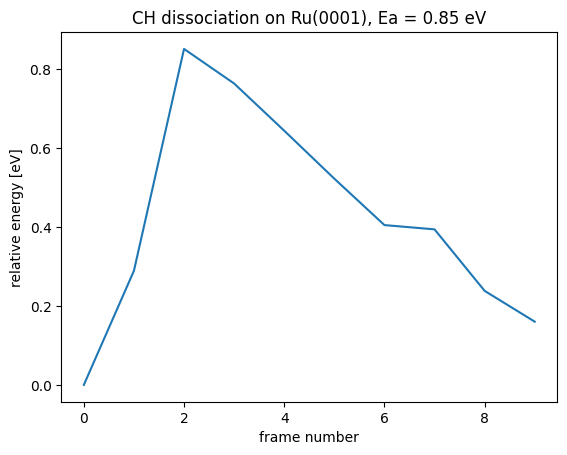

In [15]:
# Plot the reaction coordinate

es = [e - es[0] for e in es]
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"CH dissociation on Ru(0001), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

To generalize an interactive visualization, use `ase gui` from the command line or the X3D package

In [ ]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")